# CIS6800: Project 2: YOLO
### Due:
* Part A - Sept. <s>17</s> 24 at 11:59 p.m.
* Part B - Sept. 24 at 11:59 p.m.

### Instructions:
* Part A consists of parts 1-4 and is due on September <s>17th</s> 24th at 11:59 p.m. EDT.
* Part B consists of parts 5-8 and is due on September 24th at 11:59 p.m. EDT.
* As the autograder uses the definitions for functions and classes you submit,
please do not modify the name of any function or class provided.
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python. PyTorch is required, PyTorch Lightning is recommended but not required.
* You may include any code used in previous projects.
* You are encouraged to use ChatGPT, but you need to make a summary of how you used it, and the code that you have copied from it.


## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you donâ€™t need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} =
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} +
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} +
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} +
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} +
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Code

In [1]:
!pip install pytorch_lightning &> /dev/null

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [2]:
# download the data
# if this fails, you can download manually and upload to colab
# manual download link: https://drive.google.com/file/d/1NzN5m3aaQ5XpSEV6toRZiUAGvSh4Ojs4/view?usp=sharing
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1NzN5m3aaQ5XpSEV6toRZiUAGvSh4Ojs4' -O labels.npz
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1MT-J-hgix3BX7HpUumNQiX5J-By47vt1&confirm=t&uuid=e26a8982-e398-4c5e-974d-1459e3599e6c&at=AB6BwCBY6SHI_fcCMpuRgoG38F7K:1694019172385' -O images.npz

--2023-09-24 13:08:07--  https://drive.google.com/uc?export=download&id=1NzN5m3aaQ5XpSEV6toRZiUAGvSh4Ojs4
Resolving drive.google.com (drive.google.com)... 74.125.132.100, 74.125.132.102, 74.125.132.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.132.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eiltpghop2jb659pe9ml1tsi6g8p6en1/1695560850000/14871726518408366222/*/1NzN5m3aaQ5XpSEV6toRZiUAGvSh4Ojs4?e=download&uuid=151f0d6b-7f60-4d8a-a43c-90dfacfe6b92 [following]
--2023-09-24 13:08:09--  https://doc-00-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eiltpghop2jb659pe9ml1tsi6g8p6en1/1695560850000/14871726518408366222/*/1NzN5m3aaQ5XpSEV6toRZiUAGvSh4Ojs4?e=download&uuid=151f0d6b-7f60-4d8a-a43c-90dfacfe6b92
Resolving doc-00-9o-docs.googleusercontent.com (doc-00-9o-docs.googleusercontent.com)... 172.217.214.132, 2607

In [99]:
# Use this function to import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

# images = load_data('images.npz')
# raw_labels = load_data('labels.npz')

# print("Images : ", images.shape)
# print("Labels : ", raw_labels.shape)

import traceback
try:
  images = load_data('images.npz')
  raw_labels = load_data('labels.npz')
except Exception as e:
  print(e)
  traceback.print_exc()
  print("load failed, maybe manual download")

Images :  (9900, 128, 128, 3)
Labels :  (9900,)


In [93]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
def process_labels(raw_labels):
    # raw_lables: shape (N_image, (N_box, 5))
    N_image = len(raw_labels)
    #print(N_image)
    labels = np.zeros((N_image, 8, 8, 8))
    patch_size = 16
    patches = 8
    grid_cell_size=16
    for i in range(len(raw_labels)):
      #print(raw_labels[i][0,1:])
      #print("i:", i)
      for j in range(len(raw_labels[i])):

        #print("j:",j)
        x1, y1, x2, y2 = raw_labels[i][j,1:]
        x_center = (x1 + x2) / 2.
        y_center = (y1 + y2) / 2.

        x_grid = int(x_center // grid_cell_size)
        y_grid = int(y_center // grid_cell_size)

        width = (x2-x1)/128
        height = (y2-y1)/128

        x_offset = (x_center%patch_size)/patch_size
        y_offset = (y_center%patch_size)/patch_size

        class_prob = np.zeros(3)
        class_prob[int(raw_labels[i][j,0])] = 1

        labels[i, 0, x_grid, y_grid] = 1
        labels[i, 1:5, x_grid, y_grid] = [x_offset, y_offset, width, height]
        labels[i, 5:, x_grid, y_grid] = class_prob


    return labels # [N_image, 8, 8, 8]

In [39]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128, include_score=False):
    # labels: [N_image, 8, 8, 8]
    #N_image, _, grid_size, _ = labels.shape
    N_image = len(labels)
    grid_size = len(labels[0])
    grid_size = 8
    #N_box = labels.shape[1]
    raw_labels = []
    img_dim = 128
    patch_size =16
    # Iterate through each image
    for i in range(N_image):
        print("i",i)
        image_labels = []
        for x_grid in range(grid_size):
            print("x",x_grid)
            for y_grid in range(grid_size):
                # Check if there is an object in this grid cell
                print("y",y_grid)
                if labels[i, 0, x_grid, y_grid] == 1:
                    box_info = labels[i, 1:5, x_grid, y_grid]
                    x_offset, y_offset, width, height = box_info

                    x_center = x_offset*16 + x_grid*16
                    y_center = y_offset*16 + y_grid*16

                    x1 = x_center - (width * img_dim) / 2
                    y1 = y_center - (height * img_dim) / 2
                    x2 = x_center + (width * img_dim) / 2
                    y2 = y_center + (height * img_dim) / 2

                    class_probs = labels[i, 5:, x_grid, y_grid]

                    class_idx = np.argmax(class_probs)
                    raw_label = [class_idx, x1, y1, x2, y2]

                    image_labels.append(raw_label)

        raw_labels.append(image_labels)
    if include_score:
      return raw_labels # shape (N_image, (N_box, 6)); class, score, x1, y1, x2, y2
    else:
      return raw_labels # shape (N_image, (N_box, 5)); class, x1, y1, x2, y2

In [6]:
# def IOU(prediction, grnd_truth, object_idx):
#   #Extracting centers and h w
#   # cpx = 16*(prediction[:,0] + object_idx[:,0])
#   # cpy = 16*(prediction[:,1] + object_idx[:,1])
#   # wp = prediction[:,2]*128
#   # hp = prediction[:,3]*128


#   # cgx = 16*(grnd_truth[:,0] + object_idx[:,0])
#   # cgy = 16*(grnd_truth[:,1] + object_idx[:,1])
#   # wg = grnd_truth[:,2]*128
#   # hg = grnd_truth[:,3]*128

#   # # #Rescaling width and height
#   # # wp= wp * 128
#   # # hp= hp * 128
#   # # wg= wg * 128
#   # # hg= hg * 128

#   # # #Rescaling center
#   # # cpx = cpx * 16 + object_idx[:,0] * 16
#   # # cpy = cpy * 16 + object_idx[:,1] * 16
#   # # cgx = cgx * 16 + object_idx[:,0] * 16
#   # # cgy = cgy * 16 + object_idx[:,1] * 16

#   # # #Box format [x1 y1 x2 y2]
#   # # box1 =  [cpx-wp/2, cpy-hp/2, cpx+wp/2, cpy+hp/2]
#   # # box2 =  [cgx-wg/2, cgy-hg/2, cgx+wg/2, cgy+hg/2]

#   # xA = torch.max(cpx-wp/2, cgx-wg/2)
#   # yA = torch.max(cpy-hp/2, cgy-hg/2)

#   # xB = torch.min(cpx+wp/2, cgx+wg/2)
#   # yB = torch.min(cpy+hp/2, cgy+hg/2)

#   # area_intersection = torch.max(xB-xA, torch.zeros(xB.shape, dtype=xB.dtype, device="cpu")) * torch.max(yB-yA, torch.zeros(yB.shape, dtype=yB.dtype, device="cpu"))





#   # #area_union = (box1[2]-box1[0]) * (box1[3]-box1[1]) + (box2[2]-box2[0]) * (box2[3]-box2[1]) - area_intersection
#   # box1_area = hp*wp
#   # box2_area = hg*wg
#   # area_union = box1_area + box2_area


#   # iou = torch.div(area_intersection+1,area_union+1)



#   patch_size = 16
#   image_size_w = 16
#   image_size_h = 16

#   cpx = prediction[:,0]
#   cpy = prediction[:,1]
#   wp = prediction[:,2]
#   hp = prediction[:,3]


#   cgx = grnd_truth[:,0]
#   cgy = grnd_truth[:,1]
#   wg = grnd_truth[:,2]
#   hg = grnd_truth[:,3]

#   #Rescaling width and height
#   wp= wp * image_size_w
#   hp= hp * image_size_h
#   wg= wg * image_size_w
#   hg= hg * image_size_h

#   #Rescaling center
#   cpx = cpx * patch_size + object_idx[:,0] * patch_size
#   cpy = cpy * patch_size + object_idx[:,1] * patch_size
#   cgx = cgx * patch_size + object_idx[:,0] * patch_size
#   cgy = cgy * patch_size + object_idx[:,1] * patch_size

#   #Box format [x1 y1 x2 y2]
#   box1 =  [cpx-wp/2, cpy-hp/2, cpx+wp/2, cpy+hp/2]
#   box2 =  [cgx-wg/2, cgy-hg/2, cgx+wg/2, cgy+hg/2]

#   xA = torch.max(box1[0], box2[0])
#   yA = torch.max(box1[1], box2[1])

#   xB = torch.min(box1[2], box2[2])
#   yB = torch.min(box1[3], box2[3])

#   area_intersection = torch.max(xB-xA, torch.zeros(xB.shape, dtype=xB.dtype, device="cpu")) * torch.max(yB-yA, torch.zeros(yB.shape, dtype=yB.dtype, device="cpu"))

#   area_union = (box1[2]-box1[0]) * (box1[3]-box1[1]) + (box2[2]-box2[0]) * (box2[3]-box2[1]) - area_intersection

#   iou = torch.div(area_intersection+1,area_union+1)
#   return iou

In [7]:
def IOU(output ,target):
  '''
  box_1 = N x 4 (x1,y1,x2,y2)
  box_2 = N x 4 (x1,y1,x2,y2)

  (x1,y1) are coordinates of top left corner of box
  (x2,y2) are coordinates of bottom corner of box
  '''
  # N = box_1.shape[0]
  # zeros = torch.zeros(N).to(device)
  # x_1 = torch.max(box_1[:,0],box_2[:,0])
  # y_1 = torch.max(box_1[:,1],box_2[:,1])
  # x_2 = torch.min(box_1[:,2],box_2[:,2])
  # y_2 = torch.min(box_1[:,3],box_2[:,3])

  # intersect_area = torch.max(zeros,x_2 - x_1 + 1) * torch.max(zeros,y_2 - y_1 + 1)

  # box1_area = (box_1[:,2] - box_1[:,0] + 1) * (box_1[:,3] - box_1[:,1] + 1)
  # box2_area = (box_2[:,2] - box_2[:,0] + 1) * (box_2[:,3] - box_2[:,1] + 1)

  # iou = intersect_area/(box1_area + box2_area - intersect_area)

  # classification_loss = 0
  # classification_loss2 = 0
  # x_mesh, y_mesh = torch.meshgrid(torch.arange(8),torch.arange(8))
  # x_mesh = x_mesh.to(device).float()
  # y_mesh = y_mesh.to(device).float()
  # for i in range(target.shape[0]):
  #   x_pred = output[i,1,:,:]*16 + 16*y_mesh
  #   y_pred = output[i,2,:,:]*16 + 16*x_mesh
  #   x_gtruth = target[i,1,:,:]*16 + 16*y_mesh
  #   y_gtruth = target[i,2,:,:]*16 + 16*x_mesh

  #   w_pred = output[i,3,:,:]*64
  #   h_pred = output[i,4,:,:]*64
  #   w_gtruth = target[i,3,:,:]*64
  #   h_gtruth = target[i,4,:,:]*64

  #   mask = target[i,0,:,:] == 1
  #   # x_top_pred    = x_pred - w_pred
  #   # y_top_pred    = y_pred - h_pred
  #   # x_top_truth    = x_gtruth - w_gtruth
  #   # y_top_truth    = y_gtruth - h_gtruth

  #   # x_down_pred = x_pred + w_pred
  #   # y_down_pred = y_pred + h_pred
  #   # x_down_truth = x_gtruth + w_gtruth
  #   # y_down_truth = y_gtruth + h_gtruth



  #   x_top_pred    = (x_pred - w_pred)[target[i,0,:,:] == 1]
  #   y_top_pred    = (y_pred - h_pred)[target[i,0,:,:] == 1]
  #   x_top_truth    = (x_gtruth - w_gtruth)[target[i,0,:,:] == 1]
  #   y_top_truth    = (y_gtruth - h_gtruth)[target[i,0,:,:] == 1]

  #   x_down_pred = (x_pred + w_pred)[target[i,0,:,:] == 1]
  #   y_down_pred = (y_pred + h_pred)[target[i,0,:,:] == 1]
  #   x_down_truth = (x_gtruth + w_gtruth)[target[i,0,:,:] == 1]
  #   y_down_truth = (y_gtruth + h_gtruth)[target[i,0,:,:] == 1]


  #   x_top_pred_n    = (x_pred - w_pred)[target[i,0,:,:] == 0]
  #   y_top_pred_n    = (y_pred - h_pred)[target[i,0,:,:] == 0]
  #   x_top_truth_n    = (x_gtruth - w_gtruth)[target[i,0,:,:] == 0]
  #   y_top_truth_n    = (y_gtruth - h_gtruth)[target[i,0,:,:] == 0]

  #   x_down_pred_n = (x_pred + w_pred)[target[i,0,:,:] == 0]
  #   y_down_pred_n = (y_pred + h_pred)[target[i,0,:,:] == 0]
  #   x_down_truth_n = (x_gtruth + w_gtruth)[target[i,0,:,:] == 0]
  #   y_down_truth_n = (y_gtruth + h_gtruth)[target[i,0,:,:] == 0]


  #   box_1 = torch.stack([x_top_pred  , y_top_pred  , x_down_pred  , y_down_pred] ,dim = 1)
  #   box_2 = torch.stack([x_top_truth , y_top_truth , x_down_truth , y_down_truth],dim = 1)
  #   box_1_n = torch.stack([x_top_pred_n  , y_top_pred_n  , x_down_pred_n  , y_down_pred_n] ,dim = 1)
  #   box_2_n = torch.stack([x_top_truth_n , y_top_truth_n , x_down_truth_n , y_down_truth_n],dim = 1)


  #   #iou_n = torchvision.ops.box_iou(box_1_n, box_2_n)
  #   N = box_1_n.shape[0]
  #   zeros = torch.zeros(N).to(device)
  #   x_1 = torch.max(box_1_n[:,0],box_2_n[:,0])
  #   y_1 = torch.max(box_1_n[:,1],box_2_n[:,1])
  #   x_2 = torch.min(box_1_n[:,2],box_2_n[:,2])
  #   y_2 = torch.min(box_1_n[:,3],box_2_n[:,3])

  #   intersect_area = torch.max(zeros,x_2 - x_1 + 1) * torch.max(zeros,y_2 - y_1 + 1)

  #   box1_area = (box_1_n[:,2] - box_1_n[:,0] + 1) * (box_1_n[:,3] - box_1_n[:,1] + 1)
  #   box2_area = (box_2_n[:,2] - box_2_n[:,0] + 1) * (box_2_n[:,3] - box_2_n[:,1] + 1)

  #   # if(box1_area + box2_area - intersect_area==0):
  #   #   iou_n = 0
  #   # else:
  #   #   iou_n = intersect_area/(box1_area + box2_area - intersect_area)
  #   iou_n = intersect_area/(box1_area + box2_area - intersect_area)
  #   iou = torchvision.ops.box_iou(box_1, box_2)
  #   error = ((output[i,0,:,:][target[i,0,:,:] == 1] - iou)**2).sum()
  #   error2 = ((output[i,0,:,:][target[i,0,:,:] == 0] - iou_n)**2).sum()

  #   #error = (target[i,0,:,:]*(output[i,0,:,:] - iou*target[i,0,:,:])**2).sum()
  #   #error2 = ((1-target[i,0,:,:])*(output[i,0,:,:] - iou*target[i,0,:,:])**2).sum()
  #   classification_loss += error
  #   classification_loss2+=error2

  # return classification_loss, classification_loss2
  N = output.shape[0]
  iou = torch.zeros(N, 8, 8).to(device)

  for i in range(N):
    index_target = target[i,0,:,:] != 0.
    x_center_target, y_center_target = torch.where(target[i,0,:,:] != 0.)
    if len(x_center_target) != 0:

      x_target = (torch.transpose(target[i,:,index_target,],0, 1)[:,1]+x_center_target)*16
      y_target = (torch.transpose(target[i,:,index_target,],0, 1)[:,2]+y_center_target)*16
      x_output = (torch.transpose(output[i,:,index_target,],0, 1)[:,1]+x_center_target)*16
      y_output = (torch.transpose(output[i,:,index_target,],0, 1)[:,2]+y_center_target)*16

      w_target = torch.transpose(target[i,:,index_target,],0, 1)[:,3]*128
      h_target = torch.transpose(target[i,:,index_target,],0, 1)[:,4]*128
      w_output = torch.transpose(output[i,:,index_target,],0, 1)[:,3]*128
      h_output = torch.transpose(output[i,:,index_target,],0, 1)[:,4]*128

      x_r_output = (x_output + w_output/2)
      x_l_output = (x_output - w_output/2)
      y_r_output = (y_output + h_output/2)
      y_l_output = (y_output - h_output/2)

      x_r_target = (x_target + w_target/2)
      x_l_target = (x_target - w_target/2)
      y_r_target = (y_target + h_target/2)
      y_l_target = (y_target - h_target/2)

      x_r = torch.min(torch.hstack(((x_output + w_output/2).view(-1,1), (x_target + w_target/2).view(-1,1))), dim=1)
      x_l = torch.max(torch.hstack(((x_output - w_output/2).view(-1,1), (x_target - w_target/2).view(-1,1))), dim=1)
      y_r = torch.min(torch.hstack(((y_output + h_output/2).view(-1,1), (y_target + h_target/2).view(-1,1))), dim=1)
      y_l = torch.max(torch.hstack(((y_output - h_output/2).view(-1,1), (y_target - h_target/2).view(-1,1))), dim=1)

      intersect_area = (x_r[0] - x_l[0]) * (y_r[0] - y_l[0])
      union = (x_r_output - x_l_output)*(y_r_output - y_l_output) + (x_r_target - x_l_target)*(y_r_target - y_l_target) - intersect_area
      eps = 0.00001
      iou[i, x_center_target, y_center_target] = ((intersect_area + eps) / (union + eps))

  iou = torch.clamp(iou, min=0.0, max=1.0)
  return iou





In [16]:
def yolo_loss(output, target):
    # output: [B, 8, 8, 8]
    # target: [B, 8, 8, 8]
    # # indices of gridcells containing object and no object
    # lambda_coord, lambda_noobj = 5, 0.5
    # # obj_index  = target[:,0,:,:].nonzero()
    # # no_obj_index = (target[:,0,:,:]==0).nonzero()
    # # target_object    = target[obj_index[:,0],:,obj_index[:,1],obj_index[:,2]]
    # # predicted_object = output[obj_index[:,0],:,obj_index[:,1],obj_index[:,2]]
    # # predicted_object_null = output[no_obj_index[:,0],:,no_obj_index[:,1],no_obj_index[:,2]]
    # # target_object_null    = target[no_obj_index[:,0],:,no_obj_index[:,1],no_obj_index[:,2]]

    # # x = target_object[:,1]
    # # x_pred = predicted_object[:,1]
    # # y = target_object[:,2]
    # # y_pred = predicted_object[:,2]

    # # width = target_object[:,3]
    # # width_pred = predicted_object[:,3]
    # # height = target_object[:,4]
    # # height_pred = predicted_object[:,4]

    # # iou = IOU(predicted_object[:, 1:5], target_object[:, 1:5], obj_index)
    # # iou_null = IOU(predicted_object_null[:, 1:5], target_object_null[:, 1:5], no_obj_index)
    # # box_confidence_obj = predicted_object[:,0]
    # # box_confidence_obj_null = predicted_object_null[:, 0]

    # # class_prob = target_object[:,5:]
    # # class_prob_pred = predicted_object[:,5:]

    # # localization_loss = torch.sum((x-x_pred)**2 + (y-y_pred)**2)
    # # box_loss = torch.sum((torch.sqrt(width)-torch.sqrt(width_pred))**2 + (torch.sqrt(height)-torch.sqrt(height_pred))**2)

    # # obj_confidence_loss = torch.sum((iou - box_confidence_obj)**2)
    # # #torch.sum(objectness * torch.pow(output[:, 0] - confidence_score, 2))

    # # obj_null_confidence_loss= torch.sum((iou_null - box_confidence_obj_null)**2)

    # # class_prob_loss = torch.sum((class_prob - class_prob_pred)**2)

    # # loss = lambda_coord*localization_loss + lambda_coord*box_loss + obj_confidence_loss + lambda_noobj*obj_null_confidence_loss + class_prob_loss

    # # object_idx  = target[:,0,:,:].nonzero()
    # # nobject_idx = (target[:,0,:,:]==0).nonzero()

    # # target_object    = target[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]
    # # predicted_object = output[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]


    # # predicted_nobject = output[nobject_idx[:,0],:,nobject_idx[:,1],nobject_idx[:,2]]
    # # target_nobject    = target[nobject_idx[:,0],:,nobject_idx[:,1],nobject_idx[:,2]]

    # # localization_loss = torch.sum((target_object[:,1]-predicted_object[:,1])**2 +
    # #                               (target_object[:,2]-predicted_object[:,2])**2)

    # # bbox_loss         = torch.sum((torch.sqrt(target_object[:,3])-torch.sqrt(predicted_object[:,3]))**2 +
    # #                               (torch.sqrt(target_object[:,4])-torch.sqrt(predicted_object[:,4]))**2)

    # # iou = IOU(predicted_object[:, 1:5],
    # #           target_object[:, 1:5], object_idx)
    # # iou2  = IOU(predicted_nobject[:, 1:5],
    # #           target_nobject[:, 1:5], nobject_idx)

    # # #obj_confidence_loss = torch.sum((iou - predicted_object[:,0])**2)
    # # obj_confidence_loss = torch.sum((iou - predicted_object[:,0])**2)
    # # nobj_confidence_loss= torch.sum((iou2 - predicted_nobject[:, 0])**2)

    # # pc_loss = torch.sum((target_object[:,5:]-predicted_object[:,5:])**2)

    # # loss = lambda_coord*(localization_loss + bbox_loss) + obj_confidence_loss + lambda_noobj*nobj_confidence_loss + pc_loss

    # x_target = target[:,1,:,:]
    # x_output = output[:,1,:,:]
    # y_target = target[:,2,:,:]
    # y_output = output[:,2,:,:]
    # w_target = target[:,3,:,:]
    # w_output = output[:,3,:,:]
    # h_target = target[:,4,:,:]
    # h_output = output[:,4,:,:]

    # classification_loss = torch.sum( (target[:,0,:,:]*( (target[:,5,:,:] - output[:,5,:,:]) **2 )) + (target[:,0,:,:]*( (target[:,6,:,:] - output[:,6,:,:]) **2 )) + (target[:,0,:,:]*( (target[:,7,:,:] - output[:,7,:,:]) **2 )) )

    # #Localization Loss
    # localization_loss = lambda_coord*torch.sum(target[:,0,:,:] *  ((x_target - x_output)**2 + (y_target - y_output)**2))
    # box_loss = lambda_coord*torch.sum(target[:,0,:,:]*(((w_target**0.5) - (w_output**0.5))**2 + ((h_target**0.5) - (h_output**0.5))**2))
    # #Confidence Loss
    # confidence_loss, C_error_0_2  = IOU(output,target)
    # #C_error = torch.sum( truth[:,0,:,:]*((truth[:,0,:,:] - output[:,0,:,:])**2) )

    # #C_error_0 = lambda_noobj*torch.sum((1 - target[:,0,:,:])*((output[:,0])**2))
    # #print(C_error_0_2)
    # loss = classification_loss+localization_loss+ confidence_loss + box_loss+ C_error_0_2*lambda_noobj
    # return loss
    # #return loss, localization_loss, box_loss, confidence_loss, C_error_0_2*lambda_noobj,  classification_loss

    # #return loss, localization_loss, lambda_coord*box_loss, obj_confidence_loss, lambda_noobj*obj_null_confidence_loss, class_prob_loss

    N = output.shape[0]
  # iou = torch.zeros(N, 8, 8)

  ##### CUDA ######
    output = output.to(device)
    target = target.to(device)
    iou = IOU(output, target)

    localization_loss_1 = 5*torch.sum(torch.sum(target[:,0]*(torch.square(target[:,1]-output[:,1]) + torch.square(target[:,2]-output[:,2])), -1), -1)

    localization_loss_2 = 5*torch.sum(torch.sum(target[:,0]*(torch.square(target[:,3]**0.5-output[:,3]**0.5) + torch.square(target[:,4]**0.5-output[:,4]**0.5)), -1), -1)

    object_confidence_loss = torch.sum(torch.sum(target[:,0]*(torch.square(target[:,0]*iou - output[:,0])), -1), -1)

    no_object_confidence_loss = 0.5*torch.sum(torch.sum((1-target[:,0])*torch.square(target[:,0]*iou - output[:,0]), -1), -1)

    classification_loss = torch.sum(torch.sum(target[:, 0] * torch.sum((target[:, 5:] - output[:, 5:])**2, axis=1), -1), -1)

    # lambda_coord = 5
    # lambda_noobj = 0.5

    loss = localization_loss_1 + localization_loss_2  + object_confidence_loss + no_object_confidence_loss + classification_loss

    loss = torch.sum(loss)
    localization_loss_1 = torch.sum(localization_loss_1)
    localization_loss_2=torch.sum(localization_loss_2)
    object_confidence_loss = torch.sum(object_confidence_loss)
    no_object_confidence_loss = torch.sum(no_object_confidence_loss)
    classification_loss = torch.sum(classification_loss)
    return loss.float()
    #return loss.float(), localization_loss_1.float(), localization_loss_2.float(),  object_confidence_loss.float(), no_object_confidence_loss.float(), classification_loss.float()

# Part B

In [112]:
# class YOLO(pl.LightningModule):

#     def __init__(self):
#       super(YOLO,self).__init__()
#       self.relu = nn.ReLU()
#       self.sig = nn.Sigmoid()

#       self.conv1 = nn.Conv2d(3,32,4, stride = 2, padding = 1)
#       self.bn1 = nn.BatchNorm2d(32)

#       self.conv2 = nn.Conv2d(32,64,4, stride = 2, padding = 1)
#       self.bn2 = nn.BatchNorm2d(64)

#       self.conv3 = nn.Conv2d(64,128,4, stride = 2, padding = 1)
#       self.bn3 = nn.BatchNorm2d(128)

#       self.conv4 = nn.Conv2d(128,256,4, stride = 2, padding = 1)
#       self.bn4 = nn.BatchNorm2d(256)

#       self.conv5 = nn.Conv2d(256,512,4, stride = 2, padding = 1)
#       self.bn5 = nn.BatchNorm2d(512)

#       self.conv6 = nn.Conv2d(512,1024,4, stride = 2, padding = 1)
#       self.bn6 = nn.BatchNorm2d(1024)

#       self.conv7 = nn.ConvTranspose2d(1024,256,4, stride = 2, padding = 1)
#       self.bn7 = nn.BatchNorm2d(256)

#       self.conv8 = nn.ConvTranspose2d(256,64,4, stride = 2, padding = 1)
#       self.bn8 = nn.BatchNorm2d(64)

#       self.conv9 = nn.Conv2d(64,8,3, stride = 1, padding = 1)

#     def forward(self, X):
#       X = self.relu(self.bn1(self.conv1(X)))
#       X = self.relu(self.bn2(self.conv2(X)))
#       X = self.relu(self.bn3(self.conv3(X)))
#       X = self.relu(self.bn4(self.conv4(X)))
#       X = self.relu(self.bn5(self.conv5(X)))
#       X = self.relu(self.bn6(self.conv6(X)))
#       X = self.relu(self.bn7(self.conv7(X)))
#       X = self.relu(self.bn8(self.conv8(X)))
#       #X = self.relu(self.conv9(X))
#       X = self.sig(self.conv9(X))
#       return X
#     def training_step(self, batch, batch_idx):
#         ...

#     def validation_step(self, batch, batch_idx):
#         ...

#     def configure_optimizers(self):
#         ...

In [10]:
# from torch.utils.data import DataLoader, random_split,Dataset, TensorDataset
# class splitDataset(Dataset):
#   def __init__(self,images, labels, data_transforms = None):

#     self.images = images
#     self.labels = labels

#   def __len__(self):
#     return self.images.shape[0]

#   def __getitem__(self,idx):
#     return self.images[idx,:,:,:],self.labels[idx]

# def loadData2(image_path, labels_path):
#   ## use 0.8*no_images as the training data and the remaining as test data.
#   images = np.load(image_path,allow_pickle=True)['arr_0']
#   labels = np.load(labels_path,allow_pickle=True, encoding = 'latin1')['arr_0']

#   train_data = int(0.8*len(images))

#   train_images     = images[:train_data,:,:,:]
#   train_raw_labels = labels[:train_data]

#   test_images     = images[train_data:, :, :, :]
#   test_raw_labels = labels[train_data:]

#   # dataset = splitDataset(images = images, labels = labels)

#   # length_dataset = len(dataset)
#   # train_length = int(0.8*length_dataset)
#   # test_length = length_dataset - train_length

#   # train,test = random_split(dataset,[train_length,test_length])

#   # train_images = train[:][0]
#   # train_raw_labels = train[:][1]
#   # test_images = test[:][0]
#   # test_raw_labels = test[:][1]

#   return train_images, train_raw_labels, test_images, test_raw_labels


# class YOLODataset(Dataset):
#   def __init__(self,images, labels, data_transforms = None):

#     self.images = images
#     self.images = self.images.transpose(0,3,1,2)
#     self.labels = labels

#   def __len__(self):
#     return self.images.shape[0]

#   def __getitem__(self,idx):
#     return self.images[idx,:,:,:],self.labels[idx]

In [11]:
# from torch.utils.data import DataLoader, TensorDataset
# import torchvision.transforms as transforms

# ## use the processed labels and use the correct image dimensions for the pytorch loader.
# ## images = images.transpose(0,3,1,2)

# # BATCH_SIZE = 64
# # batch_size =64
# # train_loader = DataLoader(TrainDataset,batch_size=batch_size, shuffle=True)
# # test_loader = DataLoader(TrainDataset,batch_size=batch_size, shuffle=True)


# BATCH_SIZE = 64
# train_images, train_raw_labels, test_images, test_raw_labels = loadData2("images.npz", "labels.npz")

In [100]:


# train_y_labels = np.zeros((len(train_images),8,8,8))
# test_y_labels = np.zeros((len(test_images),8,8,8))
# #for i in range(len(train_images)):
# #print(train_raw_labels.size())
# # print(len(train_raw_labels))
# # print(train_raw_labels[0])
# # print(train_raw_labels[1])
# # print(train_raw_labels[2])
# # print(len(train_raw_labels[0][0]))
# #print(len(train_raw_labels[0][0][0]))

# #for i in range(len(test_images)):
# train_y_labels = process_labels(train_raw_labels)

# test_y_labels = np.zeros((len(test_images),8,8,8))
# #for i in range(len(test_images)):
# test_y_labels = process_labels(test_raw_labels)

# print(len(train_y_labels))
# # for i, label in enumerate(train_raw_labels):
# #   print(i)
# #   print(label)
# #   train_y_labels[i] = process_labels(label)

# # for i, label in enumerate(test_raw_labels):
# #   test_y_labels[i] = process_labels(label[0])


# train_dataset = YOLODataset(images = train_images, labels = train_y_labels)
# test_dataset = YOLODataset(images = test_images, labels = test_y_labels)

# train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
# test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

7920


In [ ]:
# train_size = 5500

# new_images = torch.as_tensor(images[:9900])
# labels_re = torch.as_tensor(raw_labels[:9900])
# new_images = new_images.float()

# train_data    = new_images[:train_size].to(device)
# train_labels  = labels_re[:train_size].to(device)

# val_data     = new_images[train_size:7000].to(device)
# val_labels   = labels_re[train_size:7000].to(device)

# train_set = torch.utils.data.TensorDataset(train_data, train_labels)
# train_loader = torch.utils.data.DataLoader(train_set, 50, shuffle=False )
# val_set = torch.utils.data.TensorDataset(val_data, val_labels)
# val_loader = torch.utils.data.DataLoader(val_set, 50, shuffle=False)

Epoch 1/55
tensor(230.2920, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 2/55
tensor(184.7428, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 3/55
tensor(164.3161, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 4/55
tensor(146.9186, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 5/55
tensor(136.2608, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 6/55
tensor(139.8401, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 7/55
tensor(102.8186, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 8/55
tensor(114.1338, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 9/55
tensor(95.5420, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 10/55
tensor(80.0312, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 11/55
tensor(78.3854, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 12/55
tensor(66.8030, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 13/55
tensor(54.5513, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 14/55
tensor(45.1022, device='cuda:0', grad_fn=<SumBackward0>)
Epoch 15/55
tensor(39.3551, device=

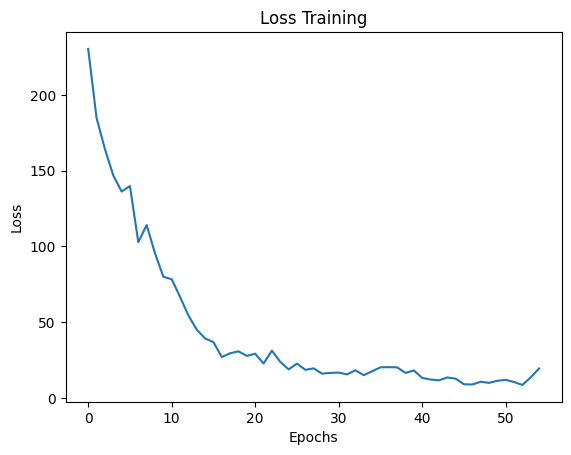

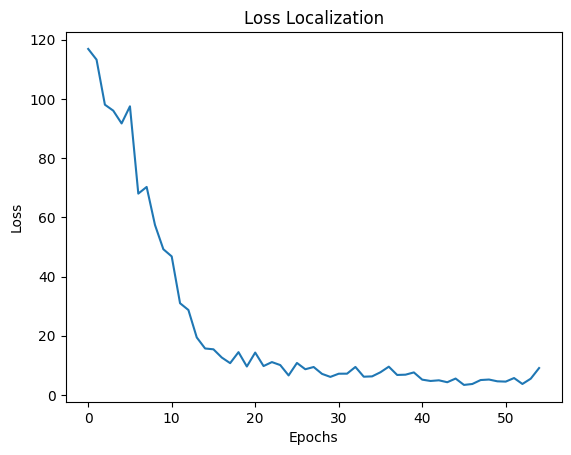

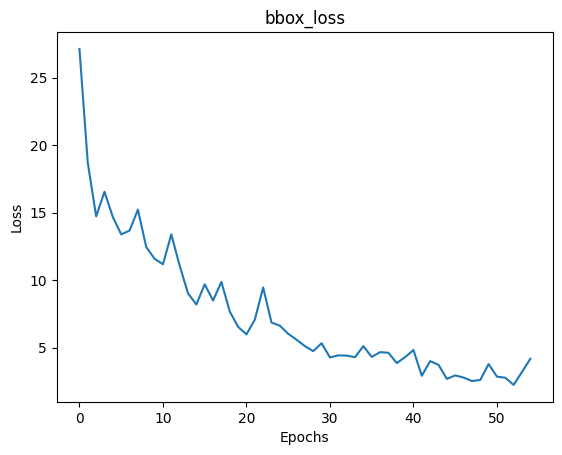

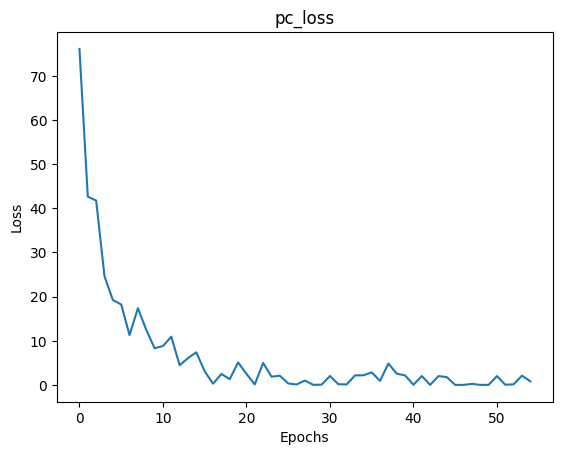

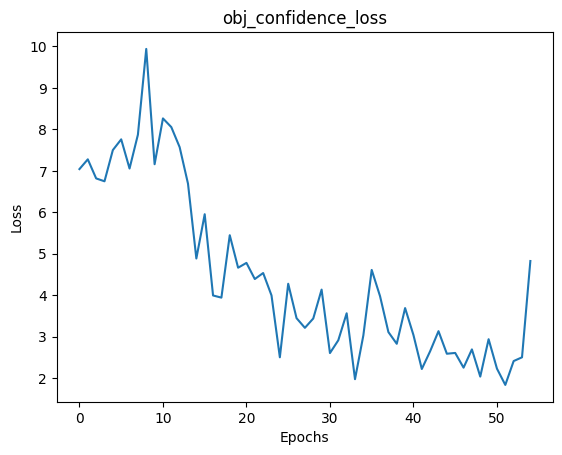

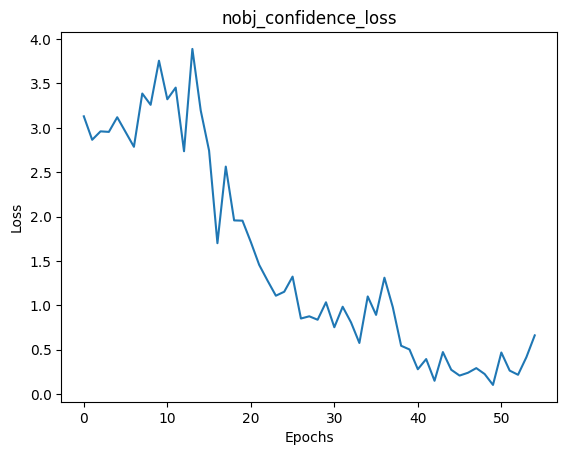

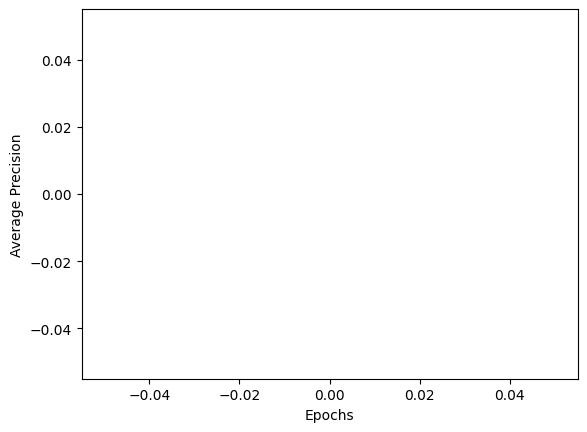

In [72]:
# resume = False # set this True if you want to resume training from a checkpoint

# yolo_net=YOLO()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ## initilize device to cpu or cuda
# yolo_net=yolo_net.to(device)
# yolo_net.train()
# learning_rate = 10e-4
# lambda_coord, lambda_noobj = 5, 0.5

# ## intialize optimizer
# optimizer=torch.optim.Adam(yolo_net.parameters(),lr=learning_rate,weight_decay=0.0006)

# # if resume == True:
# #   checkpoint = torch.load(path)
# #   yolo_net.load_state_dict(checkpoint['model_state_dict'])
# #   optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# #   epoch = checkpoint['epoch']

# num_epochs = 55 ## intialize this, atleast 20 epoch required for training
# loss_ = []
# localization_loss_=[]
# bbox_loss_=[]
# pc_loss_=[]
# obj_confidence_loss_=[]
# nobj_confidence_loss_=[]

# ap_ =[]

# for epochs in range(num_epochs):
#     ## fill in your training code
#     for data in train_loader:
#       input, labels = data
#       input = input.to(device).float()
#       labels = labels.to(device).float()
#       #print(input.shape)
#       #print(input.dtype)
#       output = yolo_net(input)
#       optimizer.zero_grad()
#       loss, localization_loss, bbox_loss, obj_confidence_loss, nobj_confidence_loss, pc_loss = yolo_loss(output, labels)
#       loss.backward()
#       optimizer.step()

#     if epochs%1==0 :
#       yolo_loss(output, labels)
#       print("Epoch %d/%d" % (epochs+1, num_epochs))
#       loss_.append(loss.item())
#       localization_loss_.append(localization_loss.item())
#       bbox_loss_.append(bbox_loss.item())
#       pc_loss_.append(pc_loss.item())
#       obj_confidence_loss_.append(obj_confidence_loss.item())
#       nobj_confidence_loss_.append(nobj_confidence_loss.item())
#       print(loss)

#       #Calculating AP : Turned off because it takes a long time
#       #ap_.append(AP_test(test_loader))

#     # path = os.path.join('','yolo_epoch'+str(epochs))
#     # torch.save({
#     #           'epoch': epochs,
#     #           'model_state_dict': yolo_net.state_dict(),
#     #           'optimizer_state_dict': optimizer.state_dict()
#     #           }, path)

# print("Completed Training")
# fig = plt.figure()
# plt.plot(loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Loss Training")
# plt.savefig("Loss_Training.png")
# plt.show()


# fig = plt.figure()
# plt.plot(localization_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Loss Localization")
# plt.savefig("Loss_Localization.png")
# plt.show()


# fig = plt.figure()
# plt.plot(bbox_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("bbox_loss")
# plt.savefig("bbox_loss.png")
# plt.show()

# fig = plt.figure()
# plt.plot(pc_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("pc_loss")
# plt.savefig("pc_loss_.png")
# plt.show()

# fig = plt.figure()
# plt.plot(obj_confidence_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("obj_confidence_loss")
# plt.savefig("obj_confidence_loss_.png")
# plt.show()


# fig = plt.figure()
# plt.plot(nobj_confidence_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("nobj_confidence_loss")
# plt.savefig("nobj_confidence_loss_.png")
# plt.show()

# fig = plt.figure()
# plt.plot(ap_)
# plt.xlabel("Epochs")
# plt.ylabel("Average Precision")
# plt.savefig("average_precision.png")
# plt.show()

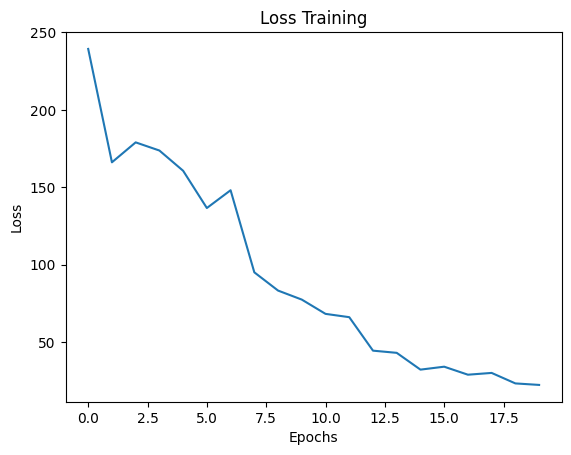

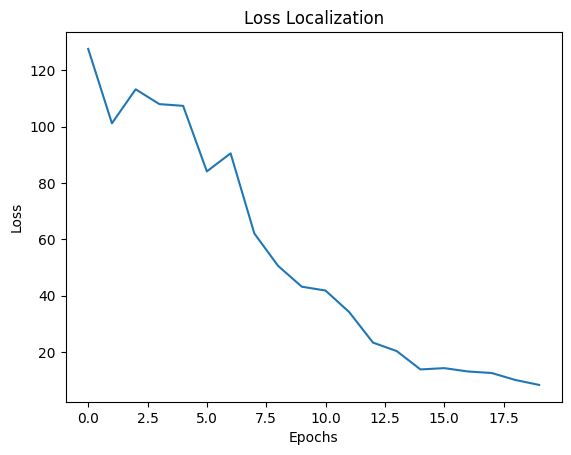

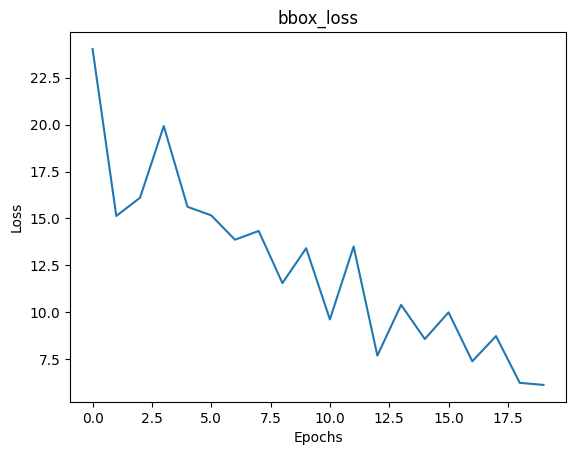

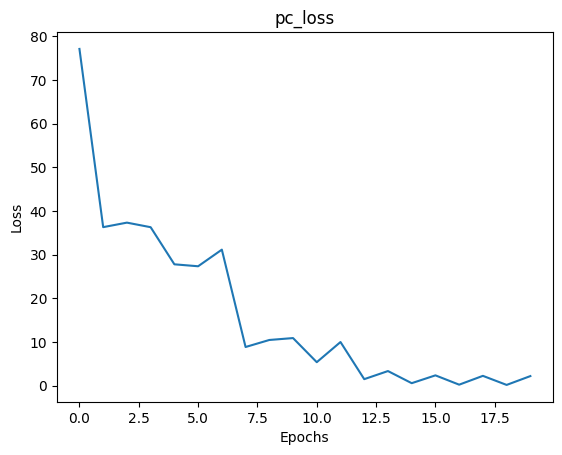

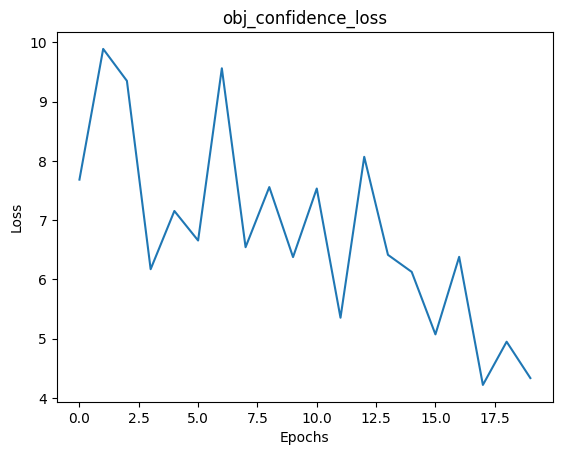

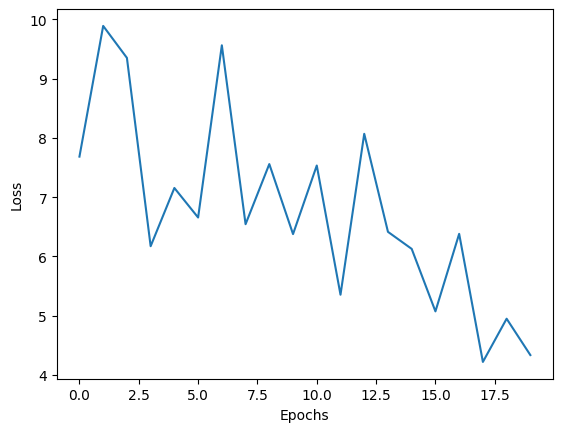

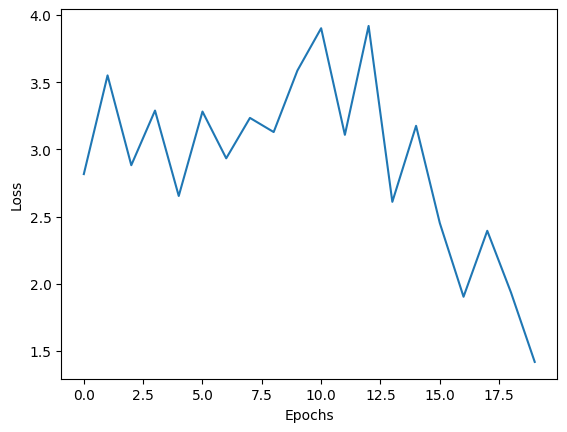

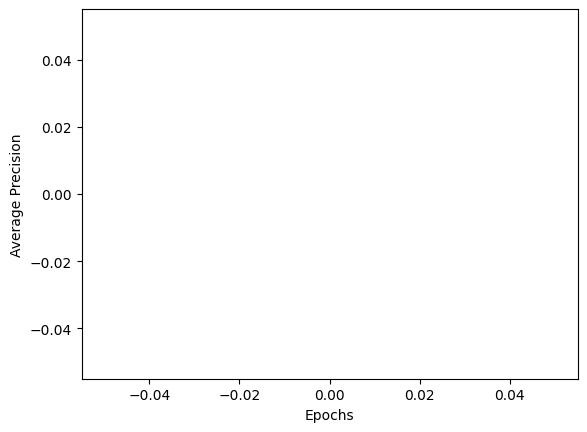

In [18]:
# fig = plt.figure()
# plt.plot(loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Loss Training")
# plt.savefig("Loss_Training.png")
# plt.show()


# fig = plt.figure()
# plt.plot(localization_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Loss Localization")
# plt.savefig("Loss_Localization.png")
# plt.show()


# fig = plt.figure()
# plt.plot(bbox_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("bbox_loss")
# plt.savefig("bbox_loss.png")
# plt.show()

# fig = plt.figure()
# plt.plot(pc_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("pc_loss")
# plt.savefig("pc_loss_.png")
# plt.show()

# fig = plt.figure()
# plt.plot(obj_confidence_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("obj_confidence_loss")
# plt.savefig("obj_confidence_loss_.png")
# plt.show()
# fig = plt.figure()


# fig = plt.figure()
# plt.plot(nobj_confidence_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("nobj_confidence_loss")
# plt.savefig("nobj_confidence_loss_.png")
# plt.show()

# # fig = plt.figure()
# # plt.plot(ap_)
# # plt.xlabel("Epochs")
# # plt.ylabel("Average Precision")
# # plt.savefig("average_precision.png")
# # plt.show()

In [238]:
# def IoU_NMS(c_mat_1, c_mat_2):
#   """
#   Input: N x 4 ---> (x_center,y_center,w,h)
#   """
#   top_x_1 = (c_mat_1[:,0] - c_mat_1[:,2]).reshape(-1,1)
#   top_y_1 = (c_mat_1[:,1] - c_mat_1[:,3]).reshape(-1,1)
#   bottom_x_1 = (c_mat_1[:,0] + c_mat_1[:,2]).reshape(-1,1)
#   bottom_y_1 = (c_mat_1[:,1] + c_mat_1[:,3]).reshape(-1,1)
#   area_box_1 = (c_mat_1[:,2]*c_mat_1[:,3]*4).reshape(-1,1)  # x4 because i divided by 64 rather than 128

#   top_x_2 = (c_mat_2[:,0] - c_mat_2[:,2]).reshape(-1,1)
#   top_y_2 = (c_mat_2[:,1] - c_mat_2[:,3]).reshape(-1,1)
#   bottom_x_2 = (c_mat_2[:,0] + c_mat_2[:,2]).reshape(-1,1)
#   bottom_y_2 = (c_mat_2[:,1] + c_mat_2[:,3]).reshape(-1,1)
#   area_box_2 = (c_mat_2[:,2]*c_mat_2[:,3]*4).reshape(-1,1)

#   inter_top_x =    np.maximum(top_x_1,top_x_2.T) #1st row shows the intersection of first box with all other boxes
#   inter_top_y =    np.maximum(top_y_1,top_y_2.T)
#   inter_bottom_x = np.minimum(bottom_x_1,bottom_x_2.T)
#   inter_bottom_y = np.minimum(bottom_y_1,bottom_y_2.T)

#   """
#   For inter_area and union_area below:
#   ith row shows the area of ith object with all other objects
#   """
#   inter_area = np.maximum(0, inter_bottom_x - inter_top_x) * np.maximum(0, inter_bottom_y - inter_top_y)
#   union_area = area_box_1 + area_box_2.T - inter_area
#   iou = inter_area/(union_area)
#   return iou


# def low_confidence_suppression(label):
#     threshold = torch.tensor(0.5)
#     return torch.where(label[0,:,:]>threshold)
#     #return label
# def non_max_suppression(label):
#     confidence_threshold = 0.6
#     area_threshold = 0.5
#     prediction = torch.tensor(label)  # Convert prediction to a PyTorch tensor

#     # Find indices of boxes with low confidence and set their scores to 0
#     low_confidence_idx = torch.where(prediction[0] < confidence_threshold)
#     prediction[0, low_confidence_idx[0], low_confidence_idx[1]] = 0

#     object_idx = torch.where(prediction[0] > 0)
#     pred_clone = prediction.clone()

#     # Create mesh grids for x and y coordinates
#     x_mesh, y_mesh = torch.meshgrid(torch.arange(8), torch.arange(8))

#     # Apply transformations to predicted values
#     pred_clone[1] = pred_clone[1] * 16 + 16 * y_mesh
#     pred_clone[2] = pred_clone[2] * 16 + 16 * x_mesh
#     pred_clone[3] = pred_clone[3] * 64
#     pred_clone[4] = pred_clone[4] * 64

#     if torch.sum(pred_clone[0] > confidence_threshold) == 0:
#         return prediction

#     objects = pred_clone[:, object_idx[0], object_idx[1]]

#     predicted_class = torch.argmax(objects[5:8, :], axis=0)
#     class_0_index = torch.where(predicted_class == 0)[0]
#     class_1_index = torch.where(predicted_class == 1)[0]
#     class_2_index = torch.where(predicted_class == 2)[0]

#     def apply_nms(class_index):
#         if len(class_index) > 1:
#             class_array = objects[:, class_index]

#             area_matrix = IoU_NMS(class_array[1:5, :].T, class_array[1:5, :].T)
#             mask = area_matrix > area_threshold

#             prob_matrix = mask * class_array[0, :]

#             for i in range(prob_matrix.shape[0]):
#                 if torch.nonzero(prob_matrix[i, i + 1:] != 0).shape[0] == 0:
#                     continue
#                 prob_row = prob_matrix[i, :]
#                 max_idx = torch.argmax(prob_row)
#                 comparison = torch.nonzero((prob_row[max_idx] > prob_row) & (prob_row != 0))[:, 0]
#                 class_array[0, comparison] = 0

#             objects[:, class_index] = class_array

#     apply_nms(class_2_index)
#     apply_nms(class_1_index)
#     apply_nms(class_0_index)

#     prediction[0, object_idx[0], object_idx[1]] = objects[0, :]

#     return prediction

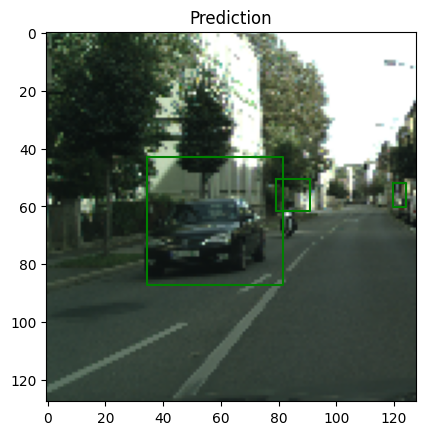

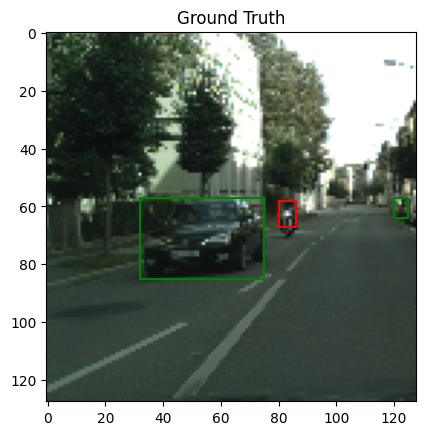

In [110]:
# images = test_images
# raw_labels = test_raw_labels
# index = 2
# image = images[index]
# image = image[np.newaxis]
# image = image.transpose(0,3,1,2)
# image = torch.tensor(image).to(device).float()

# predictions = yolo_net(image)[0].cpu().detach().numpy()
# #predictions = yolo_net(image)
# #predictions = yolo_net(torch.tensor(images[:100]).reshape(100,3,128,128))

# true_label = raw_labels[index]

# threshold = 0.5


# #Plot

# plt.figure(1)
# plt.imshow(images[index])
# plt.title("Prediction")
# # Convert the 8x8x8 back to original image
# object_detected = (predictions[0,:,:] > threshold)# == 1)
# grid_idx =  np.where(object_detected)
# #grid_idx = low_confidence_suppression(predictions)
# object_array = predictions[:,grid_idx[0],grid_idx[1]]
# object_x = (object_array[1,:]*16 + 16*grid_idx[0]).astype(int)
# object_y = (object_array[2,:]*16 + 16*grid_idx[1]).astype(int)

# half_width = object_array[3]*128 / 2
# half_height = object_array[4]*128 / 2

# for i in range(object_array.shape[1]):
#   x = object_x[i]
#   y = object_y[i]

#   w = half_width[i]
#   h = half_height[i]

#   x_coordinates = [x - w , x - w, x + w,
#                  x + w, x - w]
#   y_coordinates = [y - h, y + h, y + h,
#                  y - h, y - h]

#   if (np.argmax(object_array[5:8,i]) == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   elif (np.argmax(object_array[5:8,i]) == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   elif (np.argmax(object_array[5:8,i]) == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')
# plt.savefig("7.7.png")

# #Ground Truth
# plt.figure(3)
# plt.imshow(images[index])
# plt.title("Ground Truth")
# for i in range(true_label.shape[0]):
#   x1 = true_label[i,1]
#   y1 = true_label[i,2]
#   x2 = true_label[i,3]
#   y2 = true_label[i,4]
#   x_coordinates = [x1,x1,x2,x2,x1]
#   y_coordinates = [y1,y2,y2,y1,y1]
#   if (true_label[i,0] == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   if (true_label[i,0] == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   if (true_label[i,0] == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')
# plt.savefig("ground truth.png")

# # import cv2
# # disp_img_number = 2
# # """
# # ORIGINAL IMAGE
# # """
# # plt.figure(figsize = (8,8))
# # plt.title("Original image", size=20)
# # plt.imshow(images[disp_img_number])


# # """
# # RAW LABELS
# # """
# # image_orig_lab = images[disp_img_number].copy()

# # for i in range(0, len(raw_labels[disp_img_number])):
# #   x_ul = int(raw_labels[disp_img_number][i][1])
# #   y_ul = int(raw_labels[disp_img_number][i][2])

# #   x_br = int(raw_labels[disp_img_number][i][3])
# #   y_br = int(raw_labels[disp_img_number][i][4])

# #   color = (0,255,255)

# # image_orig_lab = cv2.rectangle(image_orig_lab, (x_ul, y_ul), (x_br, y_br), color, 1)
# # plt.figure(figsize = (8,8))
# # plt.title("Image with raw label", size=20)
# # plt.imshow(image_orig_lab)

# # """
# # RAW PREDICTIONS
# # """

# # predict_lab = reconstruct_raw_labels([predictions])

# # raw_pred_image = images[disp_img_number].copy()

# # for i in range(0, len(predict_lab[0])):
# #   # print(predict_lab[0])
# #   x_ul = int(predict_lab[0][i][1])
# #   y_ul = int(predict_lab[0][i][2])

# #   x_br = int(predict_lab[0][i][3])
# #   y_br = int(predict_lab[0][i][4])

# #   color = (0,255,255)

# #   raw_pred_image = cv2.rectangle(raw_pred_image, (x_ul, y_ul), (x_br, y_br), color, 1)
# # plt.figure(figsize = (8,8))
# # plt.title("Image with Predicted label", size=20)
# # plt.imshow(raw_pred_image)

# # """
# # LCS PREDICTIONS
# # """
# # lab1 = low_confidence_suppression(predictions[disp_img_number])

# # lcs_label = reconstruct_raw_labels([lab1.detach().numpy()], conf=False, thr = 0.00, img_dim=128)

# # lcs_pred_image = images[disp_img_number].copy()

# # for i in range(0, len(lcs_label[0])):
# #   # print(predict_lab[0])
# #   x_ul = int(lcs_label[0][i][1])
# #   y_ul = int(lcs_label[0][i][2])

# #   x_br = int(lcs_label[0][i][3])
# #   y_br = int(lcs_label[0][i][4])
# #   # print(x_ul)
# #   # print(y_ul)
# #   # print(x_br)
# #   # print(y_br)
# #   color = (0,255,255)

# #   lcs_pred_image = cv2.rectangle(lcs_pred_image, (x_ul, y_ul), (x_br, y_br), color, 1)
# # plt.figure(figsize = (8,8))
# # plt.title("Image with Predicted label LCS", size=20)
# # plt.imshow(lcs_pred_image)

# # """
# # NMS PREDICTIONS
# # """
# # lab2 = low_confidence_suppression(predictions[disp_img_number])
# # # print(lab2)
# # nms_ = non_max_suppression(torch.tensor([lab2.detach().numpy()]), nms_thres=0.0)[0]
# # # print(nms_)
# # # print(np.shape(nms_))
# # # print(np.vstack((nms_[0],nms_[2])))
# # # print(len(nms_[1]))
# # nms_123 = []
# # for x in range(0,len(nms_)):
# #   # print(nms_[x])
# #   # print(x)
# #   if len(nms_[x]) == 0:
# #     continue
# #   if len(nms_123) == 0:
# #     nms_123 = nms_[x]
# #     continue
# #   nms_123 = np.vstack((nms_123,nms_[x]))
# # # print(nms_123)

# # # nms_123 = np.vstack((nms_[0],nms_[2]))
# # nms_pred_image = images[disp_img_number].copy()
# # # print(nms_123)
# # for i in range(0, len(nms_123)):
# #   # print(predict_lab[0])
# #   x_ul = int(nms_123[i][1])
# #   y_ul = int(nms_123[i][2])

# #   x_br = int(nms_123[i][3])
# #   y_br = int(nms_123[i][4])
# #   # print(x_ul)
# #   # print(y_ul)
# #   # print(x_br)
# #   # print(y_br)
# #   color = (0,255,255)

# #   nms_pred_image = cv2.rectangle(nms_pred_image, (x_ul, y_ul), (x_br, y_br), color, 1)
# # plt.figure(figsize = (8,8))
# # plt.title("Image with Predicted label NMS", size=20)
# # plt.imshow(nms_pred_image)

In [103]:
# def IoU_NMS(c_mat_1, c_mat_2):
#   """
#   Input: N x 4 ---> (x_center,y_center,w,h)
#   """
#   top_x_1 = (c_mat_1[:,0] - c_mat_1[:,2]).reshape(-1,1)
#   top_y_1 = (c_mat_1[:,1] - c_mat_1[:,3]).reshape(-1,1)
#   bottom_x_1 = (c_mat_1[:,0] + c_mat_1[:,2]).reshape(-1,1)
#   bottom_y_1 = (c_mat_1[:,1] + c_mat_1[:,3]).reshape(-1,1)
#   area_box_1 = (c_mat_1[:,2]*c_mat_1[:,3]*4).reshape(-1,1)  # x4 because i divided by 64 rather than 128

#   top_x_2 = (c_mat_2[:,0] - c_mat_2[:,2]).reshape(-1,1)
#   top_y_2 = (c_mat_2[:,1] - c_mat_2[:,3]).reshape(-1,1)
#   bottom_x_2 = (c_mat_2[:,0] + c_mat_2[:,2]).reshape(-1,1)
#   bottom_y_2 = (c_mat_2[:,1] + c_mat_2[:,3]).reshape(-1,1)
#   area_box_2 = (c_mat_2[:,2]*c_mat_2[:,3]*4).reshape(-1,1)

#   inter_top_x =    np.maximum(top_x_1,top_x_2.T) #1st row shows the intersection of first box with all other boxes
#   inter_top_y =    np.maximum(top_y_1,top_y_2.T)
#   inter_bottom_x = np.minimum(bottom_x_1,bottom_x_2.T)
#   inter_bottom_y = np.minimum(bottom_y_1,bottom_y_2.T)

#   """
#   For inter_area and union_area below:
#   ith row shows the area of ith object with all other objects
#   """
#   inter_area = np.maximum(0, inter_bottom_x - inter_top_x) * np.maximum(0, inter_bottom_y - inter_top_y)
#   union_area = area_box_1 + area_box_2.T - inter_area
#   iou = inter_area/(union_area)
#   return iou


# def low_confidence_suppression(label):
#     threshold = 0.6
#     return torch.where(label[0,:,:]>threshold, label[:,:,:], 0)
#     return label

# def non_max_suppression(label):
#     confidence_threshold = 0.6
#     area_threshold = 0.5
#     prediction = torch.tensor(label)  # Convert prediction to a PyTorch tensor

#     # Find indices of boxes with low confidence and set their scores to 0
#     low_confidence_idx = torch.where(prediction[0] < confidence_threshold)
#     prediction[0, low_confidence_idx[0], low_confidence_idx[1]] = 0

#     object_idx = torch.where(prediction[0] > 0)
#     pred_clone = prediction.clone()

#     # Create mesh grids for x and y coordinates
#     x_mesh, y_mesh = torch.meshgrid(torch.arange(8), torch.arange(8))

#     # Apply transformations to predicted values
#     pred_clone[1] = pred_clone[1] * 16 + 16 * y_mesh
#     pred_clone[2] = pred_clone[2] * 16 + 16 * x_mesh
#     pred_clone[3] = pred_clone[3] * 64
#     pred_clone[4] = pred_clone[4] * 64

#     if torch.sum(pred_clone[0] > confidence_threshold) == 0:
#         return prediction

#     objects = pred_clone[:, object_idx[0], object_idx[1]]

#     predicted_class = torch.argmax(objects[5:8, :], axis=0)
#     class_0_index = torch.where(predicted_class == 0)[0]
#     class_1_index = torch.where(predicted_class == 1)[0]
#     class_2_index = torch.where(predicted_class == 2)[0]

#     def apply_nms(class_index):
#         if len(class_index) > 1:
#             class_array = objects[:, class_index]

#             area_matrix = IoU_NMS(class_array[1:5, :].T, class_array[1:5, :].T)
#             mask = area_matrix > area_threshold

#             prob_matrix = mask * class_array[0, :]

#             for i in range(prob_matrix.shape[0]):
#                 if torch.nonzero(prob_matrix[i, i + 1:] != 0).shape[0] == 0:
#                     continue
#                 prob_row = prob_matrix[i, :]
#                 max_idx = torch.argmax(prob_row)
#                 comparison = torch.nonzero((prob_row[max_idx] > prob_row) & (prob_row != 0))[:, 0]
#                 class_array[0, comparison] = 0

#             objects[:, class_index] = class_array

#     apply_nms(class_2_index)
#     apply_nms(class_1_index)
#     apply_nms(class_0_index)

#     prediction[0, object_idx[0], object_idx[1]] = objects[0, :]

#     return prediction

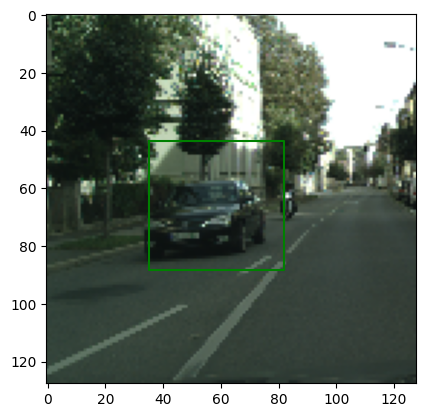

In [111]:
# confidence_threshold = 0.6
# area_threshold = 0.5
# processed_label = non_max_suppression(predictions)

# plt.figure(1)
# plt.imshow(images[index])

# # Convert the 8x8x8 back to original image
# object_detected = (processed_label[0,:,:] > threshold)# == 1)
# grid_idx =  np.where(object_detected)
# #grid_idx = low_confidence_suppression()

# object_array = processed_label[:,grid_idx[0],grid_idx[1]]
# object_x = (object_array[1,:]*16 + 16*grid_idx[0])
# object_y = (object_array[2,:]*16 + 16*grid_idx[1])
# #object_y = (object_array[2,:]*16 + 16*grid_idx[1]).astype(int)

# half_width = object_array[3]*128 / 2
# half_height = object_array[4]*128 / 2

# for i in range(object_array.shape[1]):
#   x = object_x[i]
#   y = object_y[i]

#   w = half_width[i]
#   h = half_height[i]

#   x_coordinates = [x - w , x - w, x + w,
#                  x + w, x - w]
#   y_coordinates = [y - h, y + h, y + h,
#                  y - h, y - h]
#   if (np.argmax(object_array[5:8,i]) == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   elif (np.argmax(object_array[5:8,i]) == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   elif (np.argmax(object_array[5:8,i]) == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')

# plt.savefig("after threshold.png")

In [138]:
def calculate_iou(box1, box2):
    # Calculate IoU between two bounding boxes [x1, y1, x2, y2]
    x1 = np.maximum(box1[0], box2[0])
    y1 = np.maximum(box1[1], box2[1])
    x2 = np.minimum(box1[2], box2[2])
    y2 = np.minimum(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area_box1 + area_box2 - intersection

    iou = intersection / union if union > 0 else 0
    return iou
def precision_recall_curve(predictions, targets, target_class):
    class_predictions = [p for p in predictions if p[0] == target_class]
    class_targets = [t for t in targets if t[0] == target_class]

    num_predictions = len(class_predictions)
    num_targets = len(class_targets)

    if num_targets == 0:
        return [], []

    # Sort predictions by confidence score in descending order
    class_predictions.sort(key=lambda x: x[1], reverse=True)

    true_positives = np.zeros(num_predictions)
    false_positives = np.zeros(num_predictions)

    precision = []
    recall = []

    for i in range(num_predictions):
        prediction = class_predictions[i]
        bbox_pred = prediction[2:]
        best_iou = 0

        for j in range(num_targets):
            target = class_targets[j][1:]
            iou = calculate_iou(bbox_pred, target)

            if iou > best_iou:
                best_iou = iou
                best_target_idx = j

        if best_iou >= 0.5:
            true_positives[i] = 1
            class_targets.pop(best_target_idx)
        else:
            false_positives[i] = 1

        # Calculate precision and recall at this point
        if (np.sum(true_positives) + np.sum(false_positives)) > 0:
            precision.append(np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_positives)))
            recall.append(np.sum(true_positives) / num_targets)
    return recall, precision



def average_precision(predictions, targets, target_class):
    class_predictions = [p for p in predictions if np.any(p[0] == target_class)]
    class_targets = [t for t in targets if np.any(t[0] == target_class)]

    num_predictions = len(class_predictions)
    print(num_predictions)
    num_targets = len(class_targets)
    print(num_targets)
    if num_targets == 0:
        return 0.0

    # Sort predictions by confidence score in descending order
    class_predictions.sort(key=lambda x: x[1], reverse=True)

    true_positives = np.zeros(num_predictions)
    false_positives = np.zeros(num_predictions)

    for i in range(num_predictions):
        prediction = class_predictions[i]
        bbox_pred = prediction[2:]
        best_iou = 0

        for j in range(num_targets):
            target = class_targets[j][1:]
            iou = calculate_iou(bbox_pred, target)

            if iou > best_iou:
                best_iou = iou
                best_target_idx = j

        if best_iou >= 0.5:
            true_positives[i] = 1
            class_targets.pop(best_target_idx)
        else:
            false_positives[i] = 1

    precision = np.cumsum(true_positives) / (np.cumsum(true_positives) + np.cumsum(false_positives))
    recall = np.cumsum(true_positives) / num_targets

    # Calculate average precision (AP) using the precision-recall curve
    ap = 0
    for t in np.arange(0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 11

    return ap
    #return average_precision

def mean_average_precision(predictions, targets):
    # predictions: shape (N_image, (N_box, 6)); class, score, x1, y1, x2, y2
    #   inner array of prediction (N_box, 6) is be `None` if nothing predicted
    # targets: shape (N_image, (N_box, 5)); class, x1, y1, x2, y2
    #num_classes = len(np.unique([p[0] for p in predictions]))
    num_classes = 3
    print(num_classes)

    ap_sum = 0
    valid_classes = 0

    for target_class in range(num_classes):
        #print(predictions.shape)
        ap = average_precision(predictions, targets, target_class)
        if ap > 0:
            ap_sum += ap
            valid_classes += 1

    if valid_classes == 0:
        return 0.0

    return ap_sum / valid_classes
    return mean_average_precision # float

In [156]:
# map_epoch = []
# for j in range(len(model.pred_epoch)):
#   preds = model.pred_epoch[j]
#   # print(preds[0][0])
#   mappp = 0
#   for i in range(len(predictions)):
#       nms_res = non_max_suppression(predictions[i], nms_thres=0.5)
#       mappp += mean_average_precision(nms_res, reconstruct_raw_labels(predictions[i].cpu().detach().numpy(), thr=0.5))
#   map_epoch.append(mappp/len(predictions))
# # map = mean_average_precision(predictions, true_label)
# # print(map)

NameError: ignored

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light).
  1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
  2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
  3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

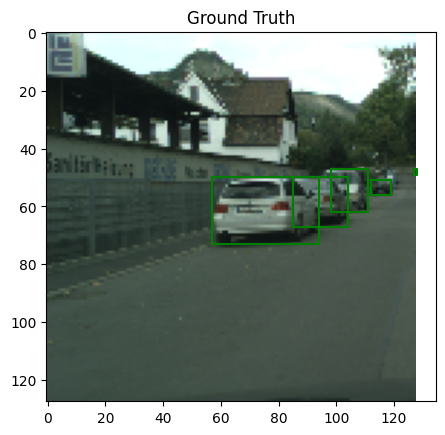

In [237]:
# # Show the chosen image with ground truth bounding boxes
# index = 1
# plt.figure(10)
# true_label = raw_labels[index]
# plt.imshow(images[index])
# plt.title("Ground Truth")
# for i in range(true_label.shape[0]):
#   x1 = true_label[i,1]
#   y1 = true_label[i,2]
#   x2 = true_label[i,3]
#   y2 = true_label[i,4]
#   x_coordinates = [x1,x1,x2,x2,x1]
#   y_coordinates = [y1,y2,y2,y1,y1]
#   if (true_label[i,0] == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   if (true_label[i,0] == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   if (true_label[i,0] == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')
# plt.savefig("ground truth10.png")

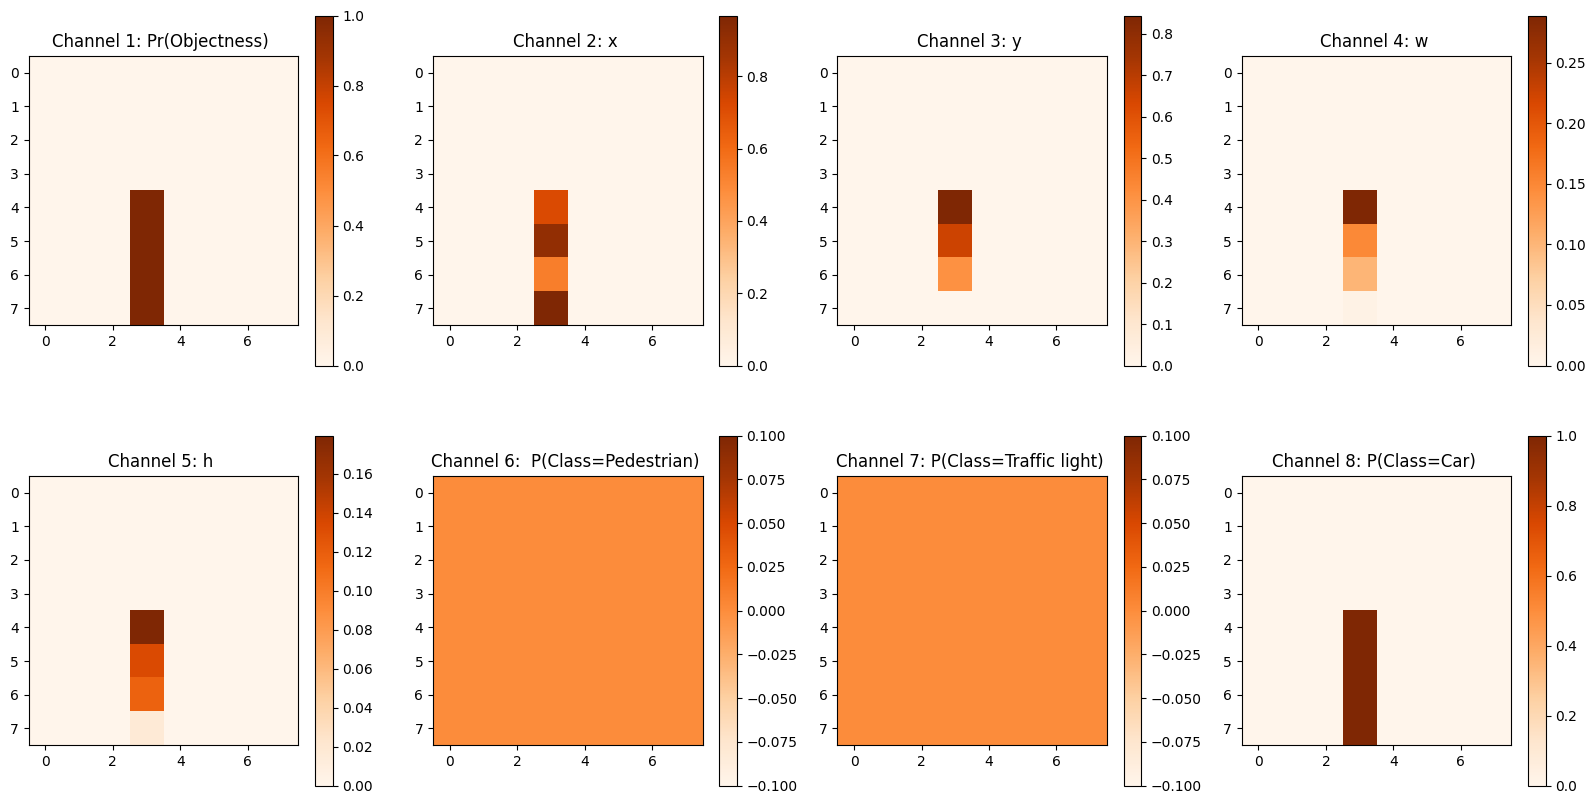

In [189]:
# import numpy as np
# import matplotlib.pyplot as plt
# index = 1
# images = test_images
# raw_labels = test_raw_labels
# true_label = raw_labels[index]
# # Example 8x8x8 label representation (replace this with your actual label data)
# labels = np.random.rand(8, 8, 8)  # Random values for demonstration
# img_number = 0  # Choose the image number to display

# # Create a figure with subplots for each channel
# fig, axarr = plt.subplots(2, 4, figsize=(20, 10))
# #fig.suptitle('Heatmaps for each channel', fontsize=30)



# labels1 = np.zeros((8, 8, 8))
# patch_size = 16
# patches = 8
# grid_cell_size=16

# for j in range(len(true_label)):

#   #print("j:",j)
#   x1, y1, x2, y2 = true_label[j,1:]
#   x_center = (x1 + x2) / 2.
#   y_center = (y1 + y2) / 2.

#   x_grid = int(x_center // grid_cell_size)
#   y_grid = int(y_center // grid_cell_size)

#   width = (x2-x1)/128
#   height = (y2-y1)/128

#   x_offset = (x_center%patch_size)/patch_size
#   y_offset = (y_center%patch_size)/patch_size

#   class_prob = np.zeros(3)
#   class_prob[int(true_label[j,0])] = 1

#   labels1[0, x_grid, y_grid] = 1
#   labels1[1:5, x_grid, y_grid] = [x_offset, y_offset, width, height]
#   labels1[5:, x_grid, y_grid] = class_prob
# #labels1 = process_labels(true_label)
# # Define colormap
# cmap = "Oranges"
# names = ["Pr(Objectness)", "x", "y", "w", "h", " P(Class=Pedestrian)", "P(Class=Traffic light)", "P(Class=Car)" ]

# # Create and display heatmaps for each channel
# for i in range(8):
#     row = i // 4
#     col = i % 4
#     heatmap = axarr[row, col].imshow(labels1[i], cmap=cmap)
#     axarr[row, col].set_title(f"Channel {i+1}: {names[i]} ")  # Replace channel_names with actual names
#     plt.colorbar(heatmap, ax=axarr[row, col])

# plt.show()


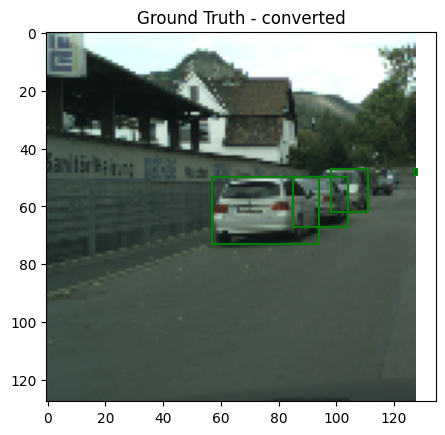

In [202]:
# # Convert back to the original representation (test cases below should pass).
# image_labels = []
# image_labels = []
# grid_size = 8
# img_dim = 128
# for x_grid in range(grid_size):
#     #print("x",x_grid)
#     for y_grid in range(grid_size):
#         # Check if there is an object in this grid cell
#         #print("y",y_grid)
#         if labels1[0, x_grid, y_grid] == 1:
#             box_info = labels1[1:5, x_grid, y_grid]
#             x_offset, y_offset, width, height = box_info

#             x_center = x_offset*16 + x_grid*16
#             y_center = y_offset*16 + y_grid*16

#             x1 = x_center - (width * img_dim) / 2
#             y1 = y_center - (height * img_dim) / 2
#             x2 = x_center + (width * img_dim) / 2
#             y2 = y_center + (height * img_dim) / 2

#             class_probs = labels1[5:, x_grid, y_grid]

#             class_idx = np.argmax(class_probs)
#             raw_label = [class_idx, x1, y1, x2, y2]

#             image_labels.append(raw_label)

# #image_labels.append(image_labels)
# #print(len(image_labels[0]))
# plt.imshow(images[index])
# plt.title("Ground Truth - converted")
# for i in range(len(image_labels)):
#   #print(i)
#   x1 = image_labels[i][1]
#   y1 = image_labels[i][2]
#   x2 = image_labels[i][3]
#   y2 = image_labels[i][4]
#   x_coordinates = [x1,x1,x2,x2,x1]
#   y_coordinates = [y1,y2,y2,y1,y1]
#   if (image_labels[i][0] == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   if (image_labels[i][0] == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   if (image_labels[i][0] == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')
# plt.savefig("ground truth2.png")


2. Implement the loss function. (3%)

3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

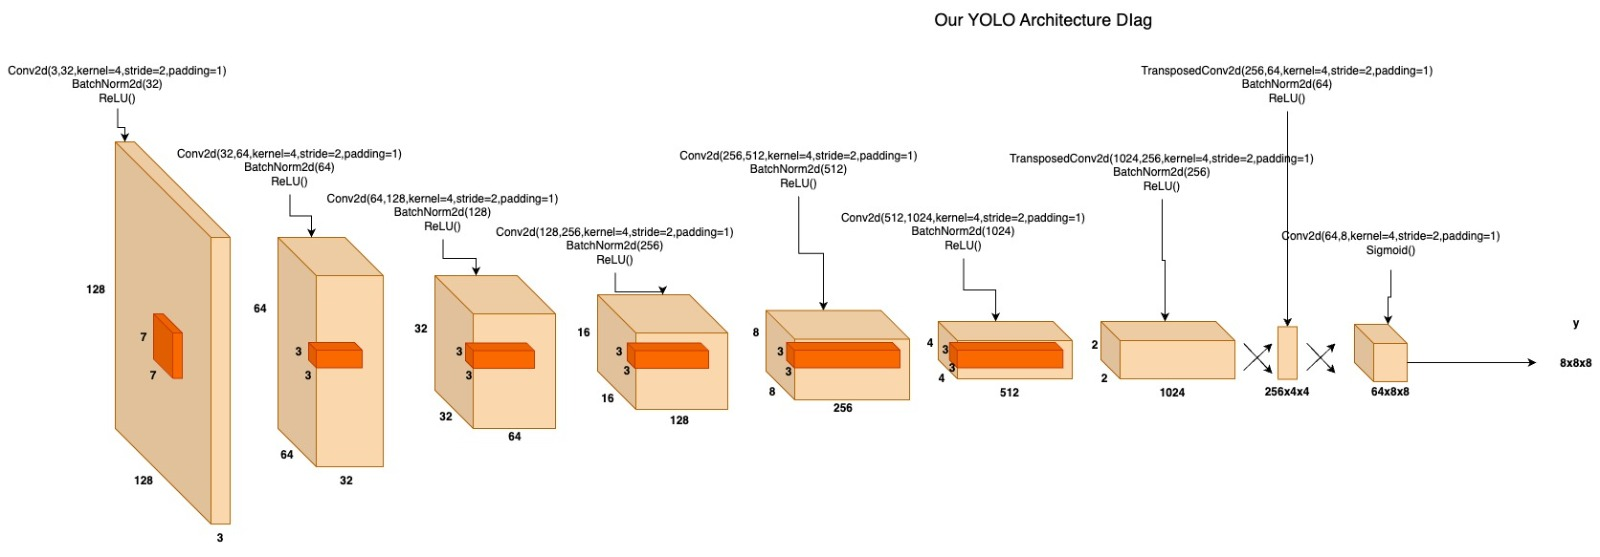

4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%)

In [ ]:
# Setup your training
...

In [ ]:
# Train your model
...

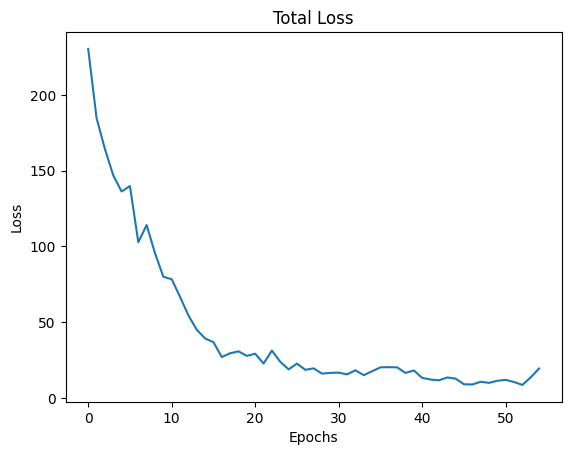

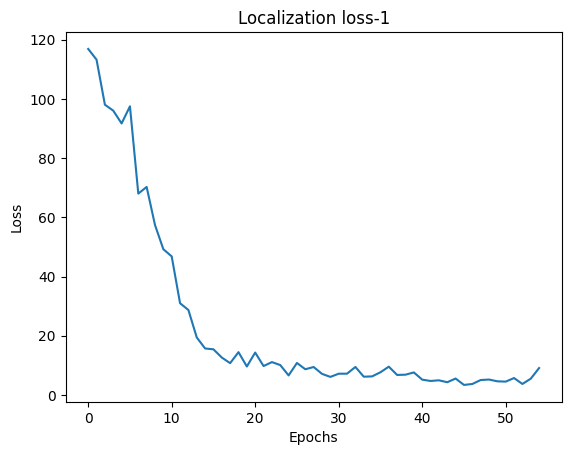

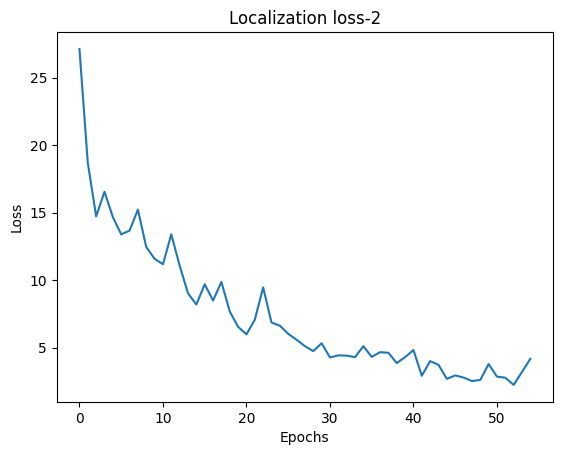

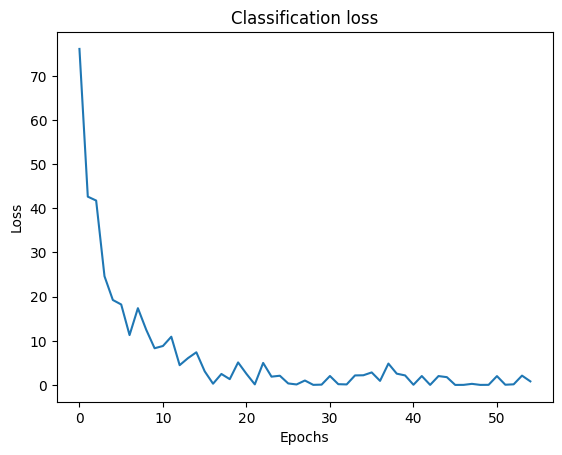

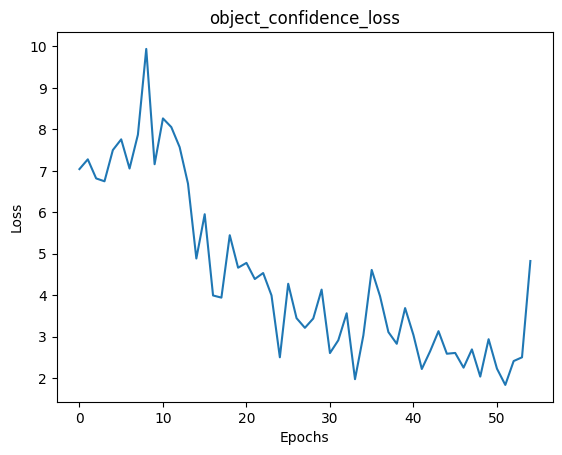

<Figure size 640x480 with 0 Axes>

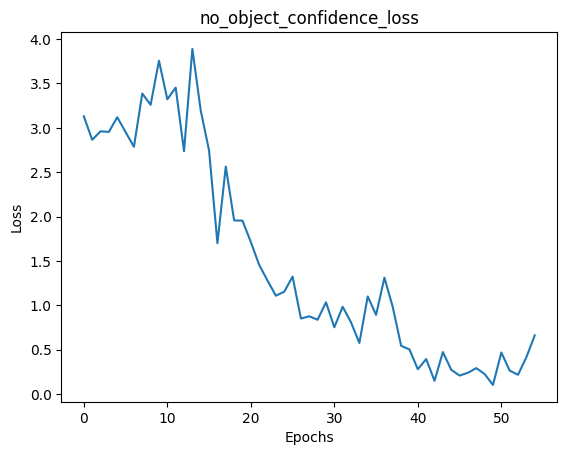

In [228]:
# # Plot the results
# fig = plt.figure()
# plt.plot(loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Total Loss")
# plt.savefig("Loss_Training.png")
# plt.show()


# fig = plt.figure()
# plt.plot(localization_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Localization loss-1")
# plt.savefig("Loss_Localization.png")
# plt.show()


# fig = plt.figure()
# plt.plot(bbox_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Localization loss-2")
# plt.savefig("bbox_loss.png")
# plt.show()

# fig = plt.figure()
# plt.plot(pc_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Classification loss")
# plt.savefig("pc_loss_.png")
# plt.show()

# fig = plt.figure()
# plt.plot(obj_confidence_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("object_confidence_loss")
# plt.savefig("obj_confidence_loss_.png")
# plt.show()
# fig = plt.figure()


# fig = plt.figure()
# plt.plot(nobj_confidence_loss_)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("no_object_confidence_loss")
# plt.savefig("nobj_confidence_loss_.png")
# plt.show()

# # fig = plt.figure()
# # plt.plot(ap_)
# # plt.xlabel("Epochs")
# # plt.ylabel("Average Precision")
# # plt.savefig("average_precision.png")
# # plt.show()

5. Show a plot of the mean Average Precision over training for your model. (10%)

In [239]:
# import warnings
# warnings.filterwarnings("ignore")

# map_epoch = []
# for j in range(len(yolo_net.pred_epoch)):
#   preds = yolo_net.pred_epoch[j]
#   # print(preds[0][0])
#   mappp = 0
#   for i in range(len(preds)):
#     nms_res = non_max_suppression(preds[i], nms_thres=0.5)
#     mappp += mean_average_precision(nms_res, reconstruct_raw_labels(preds[i].cpu().detach().numpy()))
#   map_epoch.append(mappp/len(preds))
# print(map_epoch)


# plt.plot(map_epoch)
# plt.title("MAP over epochs")
# plt.xlabel("Epochs")
# plt.ylabel("Map")
# plt.show()

AttributeError: ignored

6. For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)

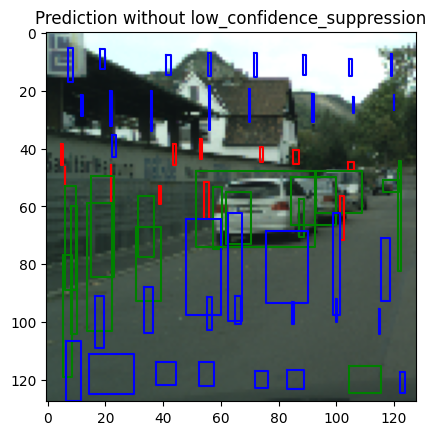

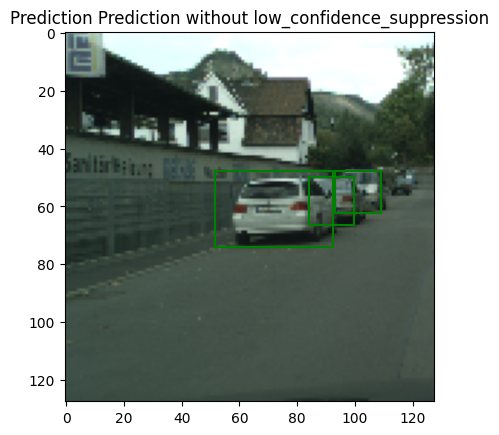

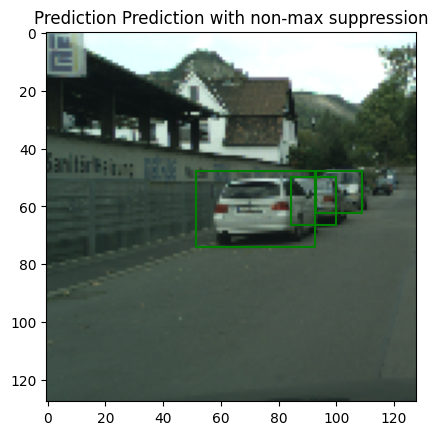

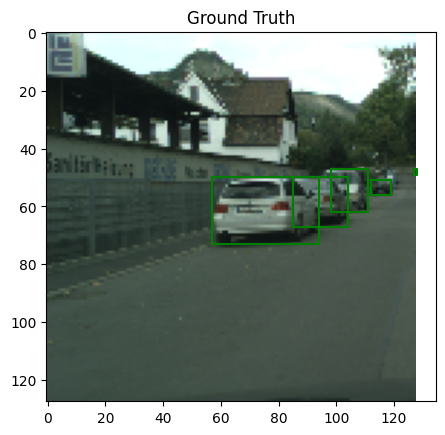

In [182]:
# images = test_images
# raw_labels = test_raw_labels
# index = 1
# image = images[index]
# image = image[np.newaxis]
# image = image.transpose(0,3,1,2)
# image = torch.tensor(image).to(device).float()

# predictions = yolo_net(image)[0].cpu().detach().numpy()
# #predictions = yolo_net(image)
# #predictions = yolo_net(torch.tensor(images[:100]).reshape(100,3,128,128))

# true_label = raw_labels[index]


# threshold = 0.0


# #Plot

# plt.figure(1)
# plt.imshow(images[index])
# plt.title("Prediction without low_confidence_suppression")
# # Convert the 8x8x8 back to original image
# object_detected = (predictions[0,:,:] > threshold)# == 1)
# grid_idx =  np.where(object_detected)
# #grid_idx = low_confidence_suppression(predictions)
# object_array = predictions[:,grid_idx[0],grid_idx[1]]
# object_x = (object_array[1,:]*16 + 16*grid_idx[0]).astype(int)
# object_y = (object_array[2,:]*16 + 16*grid_idx[1]).astype(int)

# half_width = object_array[3]*128 / 2
# half_height = object_array[4]*128 / 2

# for i in range(object_array.shape[1]):
#   x = object_x[i]
#   y = object_y[i]

#   w = half_width[i]
#   h = half_height[i]

#   x_coordinates = [x - w , x - w, x + w,
#                  x + w, x - w]
#   y_coordinates = [y - h, y + h, y + h,
#                  y - h, y - h]

#   if (np.argmax(object_array[5:8,i]) == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   elif (np.argmax(object_array[5:8,i]) == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   elif (np.argmax(object_array[5:8,i]) == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')
# plt.savefig("first.png")


# threshold = 0.6


# #Plot

# plt.figure(2)
# plt.imshow(images[index])
# plt.title("Prediction Prediction without low_confidence_suppression")
# # Convert the 8x8x8 back to original image
# object_detected = (predictions[0,:,:] > threshold)# == 1)
# grid_idx =  np.where(object_detected)
# #grid_idx = low_confidence_suppression(predictions)
# object_array = predictions[:,grid_idx[0],grid_idx[1]]
# object_x = (object_array[1,:]*16 + 16*grid_idx[0]).astype(int)
# object_y = (object_array[2,:]*16 + 16*grid_idx[1]).astype(int)

# half_width = object_array[3]*128 / 2
# half_height = object_array[4]*128 / 2

# for i in range(object_array.shape[1]):
#   x = object_x[i]
#   y = object_y[i]

#   w = half_width[i]
#   h = half_height[i]

#   x_coordinates = [x - w , x - w, x + w,
#                  x + w, x - w]
#   y_coordinates = [y - h, y + h, y + h,
#                  y - h, y - h]

#   if (np.argmax(object_array[5:8,i]) == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   elif (np.argmax(object_array[5:8,i]) == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   elif (np.argmax(object_array[5:8,i]) == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')
# plt.savefig("7.7.png")



# plt.figure(3)
# plt.imshow(images[index])
# plt.title("Prediction Prediction with non-max suppression")
# # Convert the 8x8x8 back to original image
# object_detected = (predictions[0,:,:] > threshold)# == 1)
# grid_idx =  np.where(object_detected)
# #grid_idx = low_confidence_suppression(predictions)
# object_array = predictions[:,grid_idx[0],grid_idx[1]]
# object_x = (object_array[1,:]*16 + 16*grid_idx[0]).astype(int)
# object_y = (object_array[2,:]*16 + 16*grid_idx[1]).astype(int)

# half_width = object_array[3]*128 / 2
# half_height = object_array[4]*128 / 2

# for i in range(object_array.shape[1]):
#   x = object_x[i]
#   y = object_y[i]

#   w = half_width[i]
#   h = half_height[i]

#   x_coordinates = [x - w , x - w, x + w,
#                  x + w, x - w]
#   y_coordinates = [y - h, y + h, y + h,
#                  y - h, y - h]

#   if (np.argmax(object_array[5:8,i]) == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   elif (np.argmax(object_array[5:8,i]) == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   elif (np.argmax(object_array[5:8,i]) == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')
# plt.savefig("7.5.png")

# #Ground Truth
# plt.figure(4)
# plt.imshow(images[index])
# plt.title("Ground Truth")
# for i in range(true_label.shape[0]):
#   x1 = true_label[i,1]
#   y1 = true_label[i,2]
#   x2 = true_label[i,3]
#   y2 = true_label[i,4]
#   x_coordinates = [x1,x1,x2,x2,x1]
#   y_coordinates = [y1,y2,y2,y1,y1]
#   if (true_label[i,0] == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   if (true_label[i,0] == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   if (true_label[i,0] == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')
# plt.savefig("ground truth.png")

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

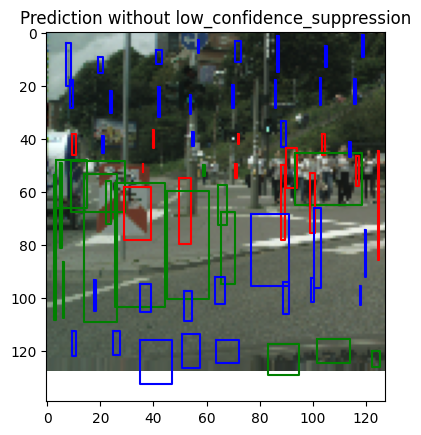

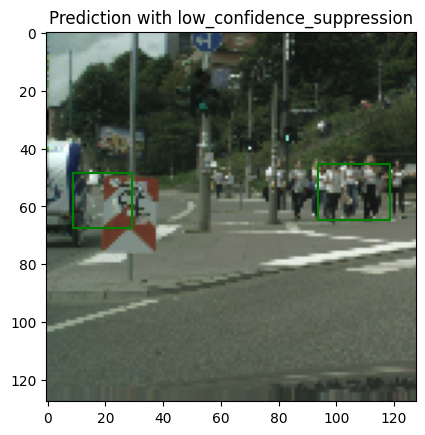

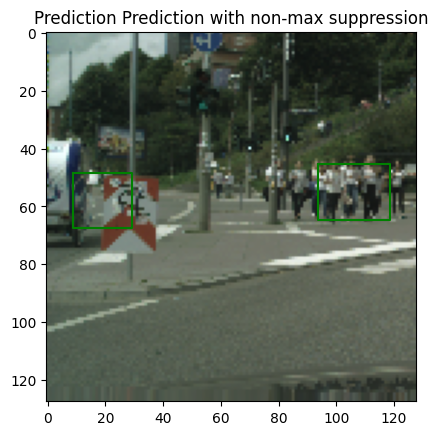

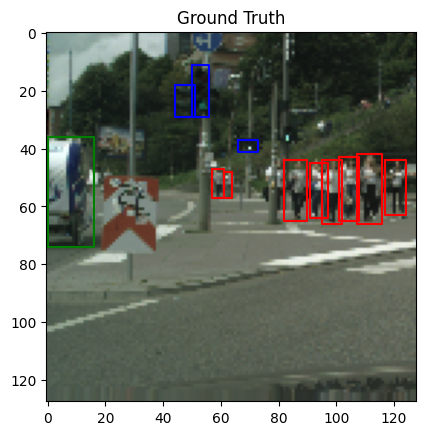

In [227]:
# images = test_images
# raw_labels = test_raw_labels
# index = 3
# image = images[index]
# image = image[np.newaxis]
# image = image.transpose(0,3,1,2)
# image = torch.tensor(image).to(device).float()

# predictions = yolo_net(image)[0].cpu().detach().numpy()
# #predictions = yolo_net(image)
# #predictions = yolo_net(torch.tensor(images[:100]).reshape(100,3,128,128))

# true_label = raw_labels[index]


# threshold = 0.0


# #Plot

# plt.figure(1)
# plt.imshow(images[index])
# plt.title("Prediction without low_confidence_suppression")
# # Convert the 8x8x8 back to original image
# object_detected = (predictions[0,:,:] > threshold)# == 1)
# grid_idx =  np.where(object_detected)
# #grid_idx = low_confidence_suppression(predictions)
# object_array = predictions[:,grid_idx[0],grid_idx[1]]
# object_x = (object_array[1,:]*16 + 16*grid_idx[0]).astype(int)
# object_y = (object_array[2,:]*16 + 16*grid_idx[1]).astype(int)

# half_width = object_array[3]*128 / 2
# half_height = object_array[4]*128 / 2

# for i in range(object_array.shape[1]):
#   x = object_x[i]
#   y = object_y[i]

#   w = half_width[i]
#   h = half_height[i]

#   x_coordinates = [x - w , x - w, x + w,
#                  x + w, x - w]
#   y_coordinates = [y - h, y + h, y + h,
#                  y - h, y - h]

#   if (np.argmax(object_array[5:8,i]) == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   elif (np.argmax(object_array[5:8,i]) == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   elif (np.argmax(object_array[5:8,i]) == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')
# plt.savefig("first.png")


# threshold = 0.6


# #Plot

# plt.figure(2)
# plt.imshow(images[index])
# plt.title("Prediction with low_confidence_suppression")
# # Convert the 8x8x8 back to original image
# object_detected = (predictions[0,:,:] > threshold)# == 1)
# grid_idx =  np.where(object_detected)
# #grid_idx = low_confidence_suppression(predictions)
# object_array = predictions[:,grid_idx[0],grid_idx[1]]
# object_x = (object_array[1,:]*16 + 16*grid_idx[0]).astype(int)
# object_y = (object_array[2,:]*16 + 16*grid_idx[1]).astype(int)

# half_width = object_array[3]*128 / 2
# half_height = object_array[4]*128 / 2

# for i in range(object_array.shape[1]):
#   x = object_x[i]
#   y = object_y[i]

#   w = half_width[i]
#   h = half_height[i]

#   x_coordinates = [x - w , x - w, x + w,
#                  x + w, x - w]
#   y_coordinates = [y - h, y + h, y + h,
#                  y - h, y - h]

#   if (np.argmax(object_array[5:8,i]) == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   elif (np.argmax(object_array[5:8,i]) == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   elif (np.argmax(object_array[5:8,i]) == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')
# plt.savefig("7.7.png")



# plt.figure(3)
# plt.imshow(images[index])
# plt.title("Prediction Prediction with non-max suppression")
# # Convert the 8x8x8 back to original image
# object_detected = (predictions[0,:,:] > threshold)# == 1)
# grid_idx =  np.where(object_detected)
# #grid_idx = low_confidence_suppression(predictions)
# object_array = predictions[:,grid_idx[0],grid_idx[1]]
# object_x = (object_array[1,:]*16 + 16*grid_idx[0]).astype(int)
# object_y = (object_array[2,:]*16 + 16*grid_idx[1]).astype(int)

# half_width = object_array[3]*128 / 2
# half_height = object_array[4]*128 / 2

# for i in range(object_array.shape[1]):
#   x = object_x[i]
#   y = object_y[i]

#   w = half_width[i]
#   h = half_height[i]

#   x_coordinates = [x - w , x - w, x + w,
#                  x + w, x - w]
#   y_coordinates = [y - h, y + h, y + h,
#                  y - h, y - h]

#   if (np.argmax(object_array[5:8,i]) == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   elif (np.argmax(object_array[5:8,i]) == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   elif (np.argmax(object_array[5:8,i]) == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')
# plt.savefig("7.5.png")

# #Ground Truth
# plt.figure(4)
# plt.imshow(images[index])
# plt.title("Ground Truth")
# for i in range(true_label.shape[0]):
#   x1 = true_label[i,1]
#   y1 = true_label[i,2]
#   x2 = true_label[i,3]
#   y2 = true_label[i,4]
#   x_coordinates = [x1,x1,x2,x2,x1]
#   y_coordinates = [y1,y2,y2,y1,y1]
#   if (true_label[i,0] == 0):#0 = pedestrian(red), 1 = traffic light(blue), 2 == car(green)
#     plt.plot(x_coordinates,y_coordinates,'r-')
#   if (true_label[i,0] == 1):
#     plt.plot(x_coordinates,y_coordinates,'b-')
#   if (true_label[i,0] == 2):
#     plt.plot(x_coordinates,y_coordinates,'g-')
# plt.savefig("ground truth.png")

8. Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)

Throughout the implementation process of YOLO, a series of challenges emerged. One predominant hurdle was the management and reshaping of tensors, especially in accommodating the varying dimensions between different layers of the network. Such challenges led to several instances of dimension mismatches, demanding thorough verification at each step. Another interesting challenge that we had to deal with the NaN values from IOU function, as dividing by zero leads to NaN values. The issue was resolved by adding a small constant in the denominator. Another challenge was the computation time.

The model performs reasonably well on detecting vehicles. However, certain classes, particularly smaller objects like pedestrian crossings, posed difficulties for our model's detection capabilities. Insightfully, on reviewing our loss function, we noticed that penalizing false negatives was exerting undue pressure on the model. Adjusting this by refining the IOU computations provided a significant improvement in these specific detections.

A noteworthy observation during training was the presence of saturated predictions. To counteract this, we introduced a tanh activation layer at the end, ensuring the predictions remained within a constrained range, thereby stabilifying the learning process.

In retrospection, the model's performance could potentially be enhanced further. One approach could be the incorporation of focal loss, which could handle the class imbalance more effectively. Moreover, fine-tuning hyperparameters, including learning rate schedules and employing techniques like gradient clipping, might yield better convergence. Finally, data augmentation strategies and leveraging a larger dataset can be instrumental in capturing a broader set of object representations, further bolstering the model's robustness.

## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output.

Please submit a pdf file alongside with the notebook, in colab, you can use "File -> Print (Ctrl+P)".

Your submission should include two files: this notebook and the pdf, but not trained model weights.

**Please comment out every training/ploting code, but only keep function definations, please do not modify the signature (name, parameters) of function defination.**

Please save before exporting!